In [362]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import sys
sys.path.insert(0, "C:/workspace/data-science//libs")
from big_numbers import contract_18_decimals_to_float

import warnings
warnings.filterwarnings('ignore')

In [363]:
tokens_addresses_to_names_dict = {
    "0x86f1e0420c26a858fc203a3645dd1a36868f18e5": "vBTC",
    "0x8c835dfaa34e2ae61775e80ee29e2c724c6ae2bb": "vETH",
    "0x5faa136fc58b6136ffdaeaac320076c4865c070f": "vAVAX",
    "0xb24f50dd9918934ab2228be7a097411ca28f6c14": "vLUNA",
    "0x151bb01c79f4516c233948d69dae39869bccb737": "vSOL",
    "0x7161c3416e08abaa5cd38e68d9a28e43a694e037": "vCRV",
    "0x333b1ea429a88d0dd48ce7c06c16609cd76f43a8": "vSAND",
    "0x2f198182ec54469195a4a06262a9431a42462373": "vLINK",
    "0x5f714b5347f0b5de9f9598e39840e176ce889b9c": "vATOM",
    "0x77d0cc9568605bfff32f918c8ffaa53f72901416": "vONE",
    "0x3fb3282e3ba34a0bff94845f1800eb93cc6850d4": "vNEAR",
    "0x2db8d2db86ca3a4c7040e778244451776570359b": "vFTM",
    "0x7eada83e15acd08d22ad85a1dce92e5a257acb92": "vFLOW",
    "0xb6599bd362120dc70d48409b8a08888807050700": "vBNB",
    "0x9482aafdced6b899626f465e1fa0cf1b1418d797": "vPERP",
    "0xbe5de48197fc974600929196239e264ecb703ee8": "vMATIC",
    "0x34235c8489b06482a99bb7fcab6d7c467b92d248": "vAAVE",
    "0x9d34f1d15c22e4c0924804e2a38cbe93dfb84bc2": "vAPE"
}

In [364]:
def liquidity_maker_individual_flow(liquidity_df: pd.DataFrame, position_changes_df: pd.DataFrame, maker: str, pool_name: str, xsize: int=15, ysize: int=14):
        """form an overview of the liquidity maker activity on the specific pool

        Args:
            liquidity_df (pd.DataFrame): liquidity changes dataframe with overall activity of all makers
                                        on all of the pools
            position_changes_df (pd.DataFrame): position changes that will be used for tracking token
                                                prices right on the Perpetual market
            maker (str): address of the maker for who overview will be made
            pool_name (str): name of the token for which overview will be made
            xsize (int, optional): horizontal size for all of the charts. Defaults to 15.
            ysize (int, optional): vertical size for entire group of charts. Defaults to 14.
        """
        maker_pool_liquidity_df = liquidity_df[(liquidity_df["pool_name"] == pool_name) &
                                                (liquidity_df["maker"] == maker)]
        lower_bound_median = maker_pool_liquidity_df["lower_bound"].median()
        lower_bound_std = maker_pool_liquidity_df["lower_bound"].std()
        upper_bound_median = maker_pool_liquidity_df["upper_bound"].median()
        upper_bound_std = maker_pool_liquidity_df["upper_bound"].std()
        maker_pool_liquidity_df = maker_pool_liquidity_df[
                (maker_pool_liquidity_df["lower_bound"] > (lower_bound_median - 2 * lower_bound_std)) &
                (maker_pool_liquidity_df["upper_bound"] < (upper_bound_median + 2 * upper_bound_std))
        ]

        filtered_position_changes_df = position_changes_df[position_changes_df["pool_name"] == pool_name]
        price_median = filtered_position_changes_df["swapped_price"].median()
        price_std = filtered_position_changes_df["swapped_price"].std()
        filtered_position_changes_df = filtered_position_changes_df[
                (filtered_position_changes_df["swapped_price"] > (price_median - 2 * price_std)) &
                (filtered_position_changes_df["swapped_price"] < (price_median + 2 * price_std))
        ]

        #   bounds respective to the price
        fig = plt.figure(figsize=(15, 20))
        ax = fig.add_subplot(5, 1, 1)
        ax.plot(maker_pool_liquidity_df["time"], maker_pool_liquidity_df["lower_bound"], 
                color='r', label='lower bound')
        ax.plot(maker_pool_liquidity_df["time"], maker_pool_liquidity_df["upper_bound"], 
                color='g', label='upper bound')
        ax.plot(maker_pool_liquidity_df["time"], 
                (maker_pool_liquidity_df["upper_bound"] + maker_pool_liquidity_df["lower_bound"]) / 2, 
                color='b', linestyle='--', label='central bound')
        ax.plot(filtered_position_changes_df[
                        (filtered_position_changes_df["timestamp"] > maker_pool_liquidity_df["timestamp"].min()) &
                        (filtered_position_changes_df["timestamp"] < maker_pool_liquidity_df["timestamp"].max())
                ]["time"],
                filtered_position_changes_df[
                        (filtered_position_changes_df["timestamp"] > maker_pool_liquidity_df["timestamp"].min()) &
                        (filtered_position_changes_df["timestamp"] < maker_pool_liquidity_df["timestamp"].max())
                ]["swapped_price"],
                color='orange', label="swap price")
        ax.set_xlabel("time")
        ax.set_ylabel("USD")
        ax.legend()
        ax.grid()
        ax.set_title("Bounds estimated by " + maker + " for " + pool_name + " respective to the price for this token")

        #   fees and operations count distributions
        ax = fig.add_subplot(5, 1, 2)
        ax.plot(maker_pool_liquidity_df["time"], maker_pool_liquidity_df["quote_fee"], color='r',
                label='collected fees')

        ax2 = ax.twinx()
        count_changes_df = (pd.to_datetime(
                filtered_position_changes_df[
                        (filtered_position_changes_df["timestamp"] > maker_pool_liquidity_df["timestamp"].min()) &
                        (filtered_position_changes_df["timestamp"] < maker_pool_liquidity_df["timestamp"].max())
                ]['time']
        ).dt.floor('d').value_counts().rename_axis('date').reset_index(name='count'))
        count_changes_df.sort_values("date", inplace=True)
        ax2.plot(count_changes_df["date"], count_changes_df["count"], color='g', linestyle='--', label='count of swaps')
        ax.set_xlabel("time")
        ax.set_ylabel("USD")
        ax2.set_ylabel("operations count")
        ax.grid()
        ax.set_title("Collected fees and count of operations in " + pool_name +" by " + maker)

        #   collected fees respective to the size of provided liquidity
        ax = fig.add_subplot(5, 1, 3)
        maker_pool_liquidity_df["fees_to_liquidity_ratio"] = ((maker_pool_liquidity_df["quote_fee"] / 
                                                                abs(maker_pool_liquidity_df["fixed_liquidity"])) * 100)
        ax.plot(maker_pool_liquidity_df["time"], maker_pool_liquidity_df["fees_to_liquidity_ratio"],
                color='g', label='ratio of fee to liquidity')
        ax.set_xlabel("time")
        ax.set_ylabel("%")
        ax.set_title("ratio of fee to provided liquidity for " + pool_name + " by " + maker)
        ax.grid(True, linestyle='--')

        #    daily sum of collected fees
        ax = fig.add_subplot(5, 1, 4)
        daily_fees_df = maker_pool_liquidity_df[["time", "quote_fee"]].set_index("time"
                                                                                ).groupby(pd.Grouper(freq='1D')).sum()
        ax.plot(daily_fees_df.index, daily_fees_df["quote_fee"], color='r', linestyle=':')
        ax.set_xlabel("time")
        ax.set_ylabel("USD")
        ax.set_title("daily sum of the quote fee for " + pool_name + " by " + maker)
        ax.grid(True, linestyle='--')

        # demonstration of the provided and extracted liquidities
        ax = fig.add_subplot(5, 1, 5)
        maker_pool_liquidity_df["liquidity_balance"] = maker_pool_liquidity_df["fixed_liquidity"].cumsum()
        ax.plot(maker_pool_liquidity_df["time"], maker_pool_liquidity_df["liquidity_balance"],
                color='b', label='balance')
        ax.plot(maker_pool_liquidity_df[maker_pool_liquidity_df["fixed_liquidity"] >= 0]["time"],
                maker_pool_liquidity_df[maker_pool_liquidity_df["fixed_liquidity"] >= 0]["fixed_liquidity"],
                color='g', marker='x', label='investments', linestyle=':')
        ax.plot(maker_pool_liquidity_df[maker_pool_liquidity_df["fixed_liquidity"] < 0]["time"],
                maker_pool_liquidity_df[maker_pool_liquidity_df["fixed_liquidity"] < 0]["fixed_liquidity"],
                color='r', marker='x', label='extractions', linestyle=':')
        ax.set_xlabel("time")
        ax.set_ylabel("USD")
        ax.set_title("Provided and extracted liquidities from the " + pool_name + " by " + maker)
        ax.legend()
        ax.grid(True, linestyle='--')

        fig.tight_layout()
        plt.show()

# Loading liquidity

In [365]:
liquidity_changes_df = pd.read_csv("liquidity_changes.csv")
liquidity_changes_df["time"] = pd.to_datetime(liquidity_changes_df["timestamp"], unit='s')
liquidity_changes_df["day_of_year"] = liquidity_changes_df["time"].dt.dayofyear
liquidity_changes_df["pool_name"] = liquidity_changes_df["base_token"].replace(tokens_addresses_to_names_dict)
liquidity_changes_df.drop(columns=["base_token", "tx_hash", "from_function_signature"], inplace=True)
liquidity_changes_df["lower_bound"] = pow(1.0001, liquidity_changes_df["lower_tick"])
liquidity_changes_df["upper_bound"] = pow(1.0001, liquidity_changes_df["upper_tick"])
liquidity_changes_df["fixed_liquidity"] = [contract_18_decimals_to_float(liquidity_record) for 
                                           liquidity_record in liquidity_changes_df["liquidity"]]
liquidity_changes_df.drop(columns=["Unnamed: 0", "quote_token", "lower_tick", "upper_tick", "liquidity", "block_number"], 
                          inplace=True)
liquidity_changes_df["central_bound"] = (liquidity_changes_df["upper_bound"] + liquidity_changes_df["lower_bound"]) / 2
liquidity_changes_df.sort_values("block_number_log_index", inplace=True)
liquidity_changes_df = liquidity_changes_df.reset_index()
liquidity_changes_df.drop(columns=["index"], inplace=True)

In [366]:
position_changes_df = pd.read_csv("position_changes.csv")
position_changes_df.drop(columns=["Unnamed: 0"], inplace=True)
position_changes_df["time"] = pd.to_datetime(position_changes_df["timestamp"], unit='s')
position_changes_df["day_of_year"] = position_changes_df["time"].dt.dayofyear
position_changes_df["pool_name"] = position_changes_df["base_token"].replace(tokens_addresses_to_names_dict)
position_changes_df.drop(columns=["base_token"], inplace=True)

In [367]:
providing_liquidity = liquidity_changes_df[liquidity_changes_df["fixed_liquidity"] >= 0]
extracting_liquidity = liquidity_changes_df[liquidity_changes_df["fixed_liquidity"] < 0]

makers_perspective_df = liquidity_changes_df[["maker", "quote_fee", "fixed_liquidity", "quote"]].groupby("maker").sum()
makers_mean_bounds_df = liquidity_changes_df[["maker", "lower_bound", "upper_bound"]].groupby("maker").mean()
makers_liquidity_providing = providing_liquidity[["maker", "fixed_liquidity"]].groupby("maker").sum()
makers_liquidity_extracting = extracting_liquidity[["maker", "fixed_liquidity"]].groupby("maker").sum()
makers_liquidity_changes_counts = liquidity_changes_df[["maker", "fixed_liquidity"]].groupby("maker").count()

makers_perspective_df.sort_index(inplace=True)
makers_mean_bounds_df.sort_index(inplace=True)
makers_liquidity_providing.sort_index(inplace=True)
makers_liquidity_extracting.sort_index(inplace=True)

makers_perspective_df["mean_lower_bound"] = makers_mean_bounds_df["lower_bound"]
makers_perspective_df["mean_upper_bound"] = makers_mean_bounds_df["upper_bound"]
makers_perspective_df["overall_provided_liquidity"] = makers_liquidity_providing["fixed_liquidity"]
makers_perspective_df["overall_extracted_liquidity"] = makers_liquidity_extracting["fixed_liquidity"]
makers_perspective_df["changes_count"] = makers_liquidity_changes_counts["fixed_liquidity"]

makers_perspective_df.sort_values("quote_fee", inplace=True)
makers_perspective_df

quote_fee  fixed_liquidity  \
maker                                                                       
0x7cc38a05436c19b6bbc6f36c319e0b88bfc8b71a  0.000000e+00     3.024958e+00   
0x76a0d0e3e13e91923d01d11d291e18ddc76061da  0.000000e+00     2.121648e-01   
0x77dfe2ae646ae67c23189d49bae5985bed8f851e  0.000000e+00     2.608519e-01   
0x77f07ab7b444c7c9fcfafc76c053a810cd6203cb  0.000000e+00     1.723370e+00   
0x78366a722edd130ca1b05b269bf3c0e50239c9a1  0.000000e+00     1.574986e+01   
...                                                  ...              ...   
0xe77dd81813bd06d74a30d1b2c07418906456498e  4.896962e+05     1.308155e+07   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd  5.051075e+05    -8.342415e+05   
0x70332de459d5554a9a310a7c4f7c6069c73604f9  7.409911e+05    -1.957784e+07   
0xf8489bcef22d3282bb884b9e9cc708bb465c075e  1.105782e+06     3.492460e-10   
0x9c1e0c67aa30c063f341885b12cb81cc94613fc7  1.949788e+06    -3.979039e-09   

                                                   quote  mean_lower_bound  \
maker                                                                        
0x7cc38a05436c19b6bbc6f36c319e0b88bfc8b71a  0.000000e+00      37178.050845   
0x76a0d0e3e13e91923d01d11d291e18ddc76061da  1.130000e+00       2050.048490   
0x77dfe2ae646ae67c23189d49bae5985bed8f851e  1.510000e+00       2469.101075   
0x77f07ab7b444c7c9fcfafc76c053a810cd6203cb  0.000000e+00      38540.774401   
0x78366a722edd130ca1b05b269bf3c0e50239c9a1  2.000000e+00          1.134275   
...                                                  ...               ...   
0xe77dd81813bd06d74a30d1b2c07418906456498e  1.005260e+07         12.136231   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd  4.532833e+06         77.977092   
0x70332de459d5554a9a310a7c4f7c6069c73604f9  3.089670e+06          3.969630   
0xf8489bcef22d3282bb884b9e9cc708bb465c075e -3.715146e+06         62.155604   
0x9c1e0c67aa30c063f341885b12cb81cc94613fc7  3.100574e+07      14698.758998   

                                            mean_upper_bound  \
maker                                                          
0x7cc38a05436c19b6bbc6f36c319e0b88bfc8b71a      4.450981e+04   
0x76a0d0e3e13e91923d01d11d291e18ddc76061da      3.064374e+03   
0x77dfe2ae646ae67c23189d49bae5985bed8f851e      3.690766e+03   
0x77f07ab7b444c7c9fcfafc76c053a810cd6203cb      4.641893e+04   
0x78366a722edd130ca1b05b269bf3c0e50239c9a1      1.705696e+00   
...                                                      ...   
0xe77dd81813bd06d74a30d1b2c07418906456498e      1.518723e+01   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd      1.665579e+02   
0x70332de459d5554a9a310a7c4f7c6069c73604f9      5.065420e+00   
0xf8489bcef22d3282bb884b9e9cc708bb465c075e      1.169285e+02   
0x9c1e0c67aa30c063f341885b12cb81cc94613fc7      6.821000e+35   

                                            overall_provided_liquidity  \
maker                                                                    
0x7cc38a05436c19b6bbc6f36c319e0b88bfc8b71a                3.024958e+00   
0x76a0d0e3e13e91923d01d11d291e18ddc76061da                2.121648e-01   
0x77dfe2ae646ae67c23189d49bae5985bed8f851e                2.608519e-01   
0x77f07ab7b444c7c9fcfafc76c053a810cd6203cb                1.723370e+00   
0x78366a722edd130ca1b05b269bf3c0e50239c9a1                1.574986e+01   
...                                                                ...   
0xe77dd81813bd06d74a30d1b2c07418906456498e                6.156079e+10   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd                4.602895e+09   
0x70332de459d5554a9a310a7c4f7c6069c73604f9                1.020124e+11   
0xf8489bcef22d3282bb884b9e9cc708bb465c075e                5.587856e+08   
0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                1.083119e+09   

                                            overall_extracted_liquidity  \
maker                                                                     
0x7cc38a05436c19b6bbc6f36c319e0b88bfc8b71a                          NaN   
0x76a0d0e

In [368]:
liquidity_changes_df

id  \
0       0xec1e410b931f920c4aa3ae105e63463142b310fbe959...   
1       0x7dba9c535f6c595ab39eeec818d89b34783442bafa81...   
2       0xc438a7cd8fee202ce2b53761811ef05f85095933b27e...   
3       0x7871b4fe6113ac31c8be911146b109575cfb9ee90b13...   
4       0x653f9413a9c8df27d2800bbb71f06fd20b6d825b3d38...   
...                                                   ...   
130054  0xf3155f56c66c05c95611e7947304853aab760c5ff395...   
130055  0xc8c4310f0bb74d949669849479190ba4b1eebee33f58...   
130056  0x8e7f48783a1d80dc4a058e7595f89d5d485d9d054f27...   
130057  0xb7473ff85536e28acf2175d68acbbf68351a02dd7a7a...   
130058  0x5f2282b63e5dbedec17f288383170fd4a5e70bbdf8ab...   

                                             maker         base  \
0       0x9c1e0c67aa30c063f341885b12cb81cc94613fc7     0.000921   
1       0x9c1e0c67aa30c063f341885b12cb81cc94613fc7     0.012181   
2       0x9c1e0c67aa30c063f341885b12cb81cc94613fc7     3.572179   
3       0x9c1e0c67aa30c063f341885b12cb81cc94613fc7    46.254982   
4       0x35952141922ee99a04e016c967c3f0ad589ea958     0.100000   
...                                            ...          ...   
130054  0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420 -1683.962836   
130055  0x377e6326a8e2ce4a856d31605ca33505ad2b57b1  1435.815543   
130056  0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420  1708.506923   
130057  0x377e6326a8e2ce4a856d31605ca33505ad2b57b1  -331.643015   
130058  0x377e6326a8e2ce4a856d31605ca33505ad2b57b1   329.868332   

                quote   quote_fee  block_number_log_index   timestamp  \
0           50.000000    0.000000               515552004  1638000985   
1           50.000000    0.000000               515554004  1638000985   
2       200000.000000    0.000000               515555003  1638000985   
3       200000.000000    0.000000               515557003  1638000985   
4          472.798469    0.000000               516478004  1638003992   
...               ...         ...                     ...         ...   
130054       0.000000  144.993911             11554393008  1655117811   
130055    4999.462445    0.000000             11554604003  1655117891   
130056       0.000000    0.000000             11554671003  1655117952   
130057   -4978.735548    2.235039             11555163007  1655118198   
130058    5000.000000    0.000000             11555456004  1655118289   

                      time  day_of_year pool_name   lower_bound   upper_bound  \
0      2021-11-27 08:16:25          331      vBTC  2.954278e-39  3.384921e+38   
1      2021-11-27 08:16:25          331      vETH  2.954278e-39  3.384921e+38   
2      2021-11-27 08:16:25          331      vBTC  5.171263e+04  5.692287e+04   
3      2021-11-27 08:16:25          331      vETH  3.895536e+03  4.313830e+03   
4      2021-11-27 09:06:32          331      vETH  3.990155e+03  4.288026e+03   
...                    ...          ...       ...           ...           ...   
130054 2022-06-13 10:56:51          164     vAAVE  5.948926e+01  7.164952e+01   
130055 2022-06-13 10:58:11          164      vAPE  3.478628e-01  3.487682e+01   
130056 2022-06-13 10:59:12          164     vAAVE  5.877969e+01  7.037143e+01   
130057 2022-06-13 11:03:18          164     vAVAX  1.512826e+00  1.516763e+02   
130058 2022-06-13 11:04:49          164     vAVAX  1.512826e+00  1.516763e+02   

        fixed_liquidity  central_bound  
0              0.214579   1.692461e+38  
1              0.780407   1.692461e+38  
2          35648.835497   5.431775e+04  
3         120851.329740   4.104683e+03  
4            386.315245   4.139091e+03  
...                 ...            ...  
130054   -146260.729784   6.556939e+01  
130055      3917.139686   1.761234e+01  
130056    152196.723027   6.457556e+01  
130057     -1878.686957   7.659458e+01  
130058      1877.644621   7.659458e+01  

[130059 rows x 14 columns]

Here is shown principle of constructing an overview of the activity for the maker on the specific pool

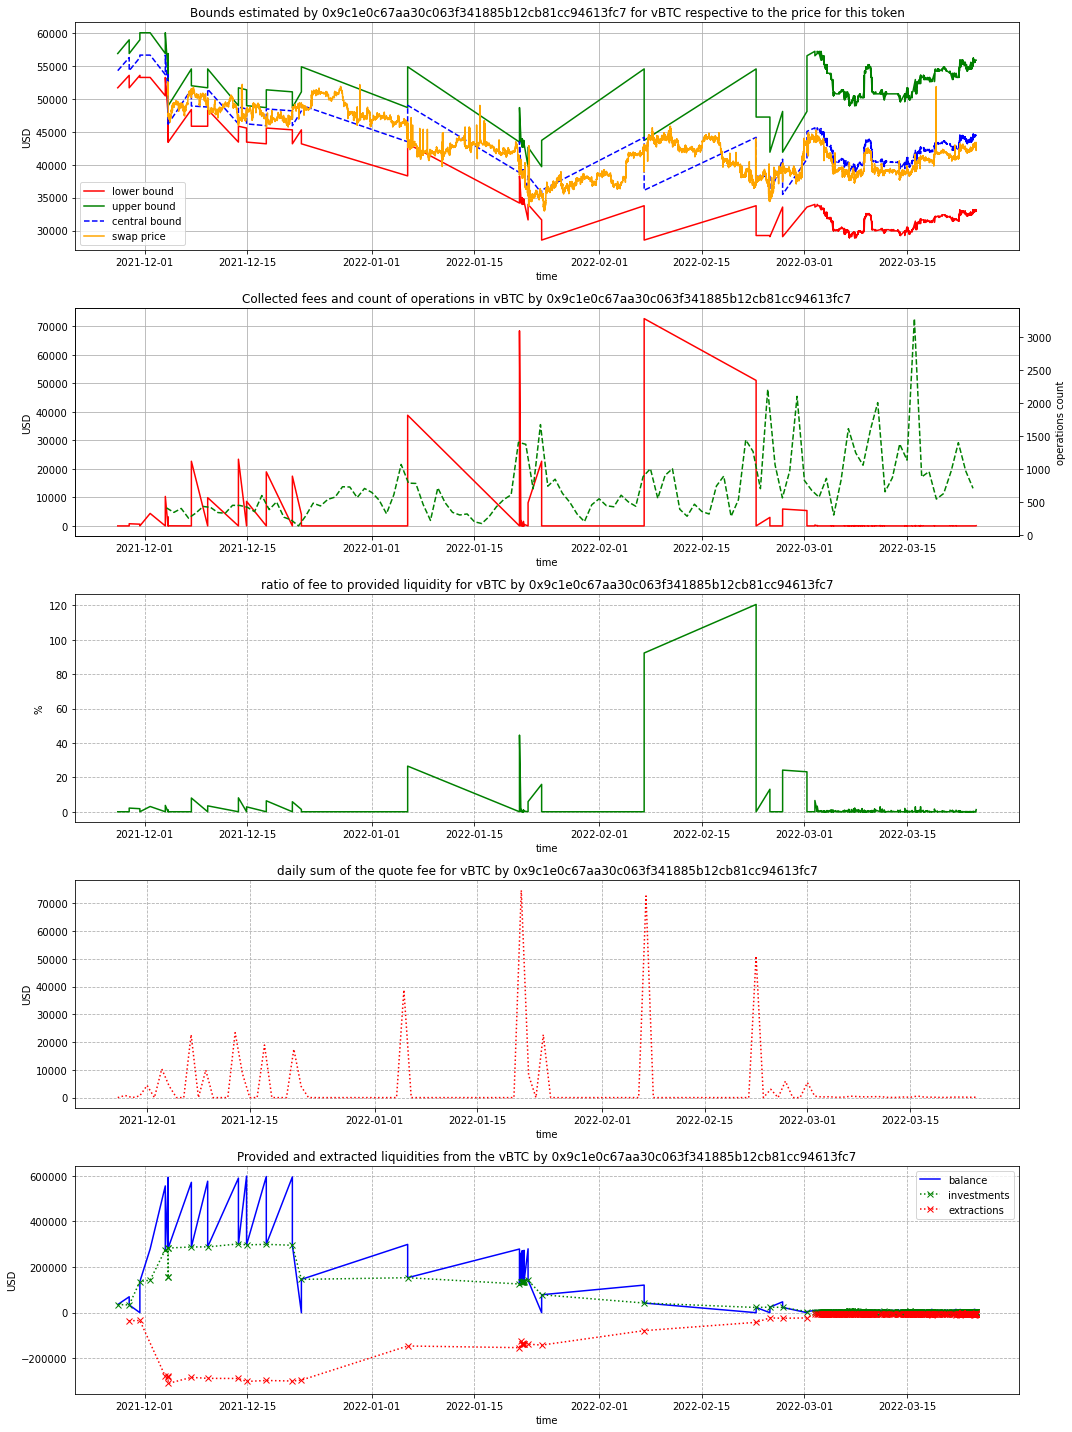

In [369]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df,
                               "0x9c1e0c67aa30c063f341885b12cb81cc94613fc7", "vBTC")

In [370]:
makers_perspective_df.sort_values("changes_count")

quote_fee  fixed_liquidity  \
maker                                                                        
0x7cc38a05436c19b6bbc6f36c319e0b88bfc8b71a       0.000000     3.024958e+00   
0xa1bfe87c09d05e3349fe661d62e8cee215db5a57       0.000000     1.958486e-02   
0xa1adf3dda8d7f62cbab65a86926ba46ac265cf2e       0.000000     3.228415e+00   
0xa1622da220732bd59cde8de6ca6f07cb398bb1f7       0.000000     2.525356e-01   
0xa080aedd8030e20f39faf056412fc6e32e1de78b       0.000000     1.126201e+00   
...                                                   ...              ...   
0x675e328b73e15cd41acd2828b83b417687c36bba  170409.008415     1.798917e+04   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd  505107.478784    -8.342415e+05   
0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be  308325.682886    -6.428470e+05   
0x70332de459d5554a9a310a7c4f7c6069c73604f9  740991.144164    -1.957784e+07   
0xe77dd81813bd06d74a30d1b2c07418906456498e  489696.174135     1.308155e+07   

                                                   quote  mean_lower_bound  \
maker                                                                        
0x7cc38a05436c19b6bbc6f36c319e0b88bfc8b71a  0.000000e+00      3.717805e+04   
0xa1bfe87c09d05e3349fe661d62e8cee215db5a57  1.000000e+00      2.954278e-39   
0xa1adf3dda8d7f62cbab65a86926ba46ac265cf2e  5.000000e+00      7.070295e+00   
0xa1622da220732bd59cde8de6ca6f07cb398bb1f7  1.540000e+00      2.606091e+03   
0xa080aedd8030e20f39faf056412fc6e32e1de78b  6.000000e+01      2.954278e-39   
...                                                  ...               ...   
0x675e328b73e15cd41acd2828b83b417687c36bba -3.682497e+05      9.443748e+03   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd  4.532833e+06      7.797709e+01   
0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be  6.783113e+06      1.037030e+02   
0x70332de459d5554a9a310a7c4f7c6069c73604f9  3.089670e+06      3.969630e+00   
0xe77dd81813bd06d74a30d1b2c07418906456498e  1.005260e+07      1.213623e+01   

                                            mean_upper_bound  \
maker                                                          
0x7cc38a05436c19b6bbc6f36c319e0b88bfc8b71a      4.450981e+04   
0xa1bfe87c09d05e3349fe661d62e8cee215db5a57      3.384921e+38   
0xa1adf3dda8d7f62cbab65a86926ba46ac265cf2e      1.770516e+01   
0xa1622da220732bd59cde8de6ca6f07cb398bb1f7      3.918979e+03   
0xa080aedd8030e20f39faf056412fc6e32e1de78b      3.384921e+38   
...                                                      ...   
0x675e328b73e15cd41acd2828b83b417687c36bba      1.596039e+04   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd      1.665579e+02   
0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be      1.764335e+02   
0x70332de459d5554a9a310a7c4f7c6069c73604f9      5.065420e+00   
0xe77dd81813bd06d74a30d1b2c07418906456498e      1.518723e+01   

                                            overall_provided_liquidity  \
maker                                                                    
0x7cc38a05436c19b6bbc6f36c319e0b88bfc8b71a                3.024958e+00   
0xa1bfe87c09d05e3349fe661d62e8cee215db5a57                1.958486e-02   
0xa1adf3dda8d7f62cbab65a86926ba46ac265cf2e                3.228415e+00   
0xa1622da220732bd59cde8de6ca6f07cb398bb1f7                2.525356e-01   
0xa080aedd8030e20f39faf056412fc6e32e1de78b                1.126201e+00   
...                                                                ...   
0x675e328b73e15cd41acd2828b83b417687c36bba                8.197473e+09   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd                4.602895e+09   
0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be                1.340898e+10   
0x70332de459d5554a9a310a7c4f7c6069c73604f9                1.020124e+11   
0xe77dd81813bd06d74a30d1b2c07418906456498e                6.156079e+10   

                                            overall_extracted_liquidity  \
maker                                                                     
0x7cc38a05436c19b6bbc6f36c319e0b88bfc8b71a                          NaN 

# Analysis of the ratio for top traders by amount of performed changes

Considering that previous notebook contains information about results of maker's activity for specified pool overall it is required to review now closely only those traders that have different strategies in trading and also to see anomalies in the distributions.

The most important moment about visual analysis at this stage is to find cases when price will deviate too far and to see how makers adapt to the changes (if they detect those anomalous changes).

# SAND

## Check of the overall distribution

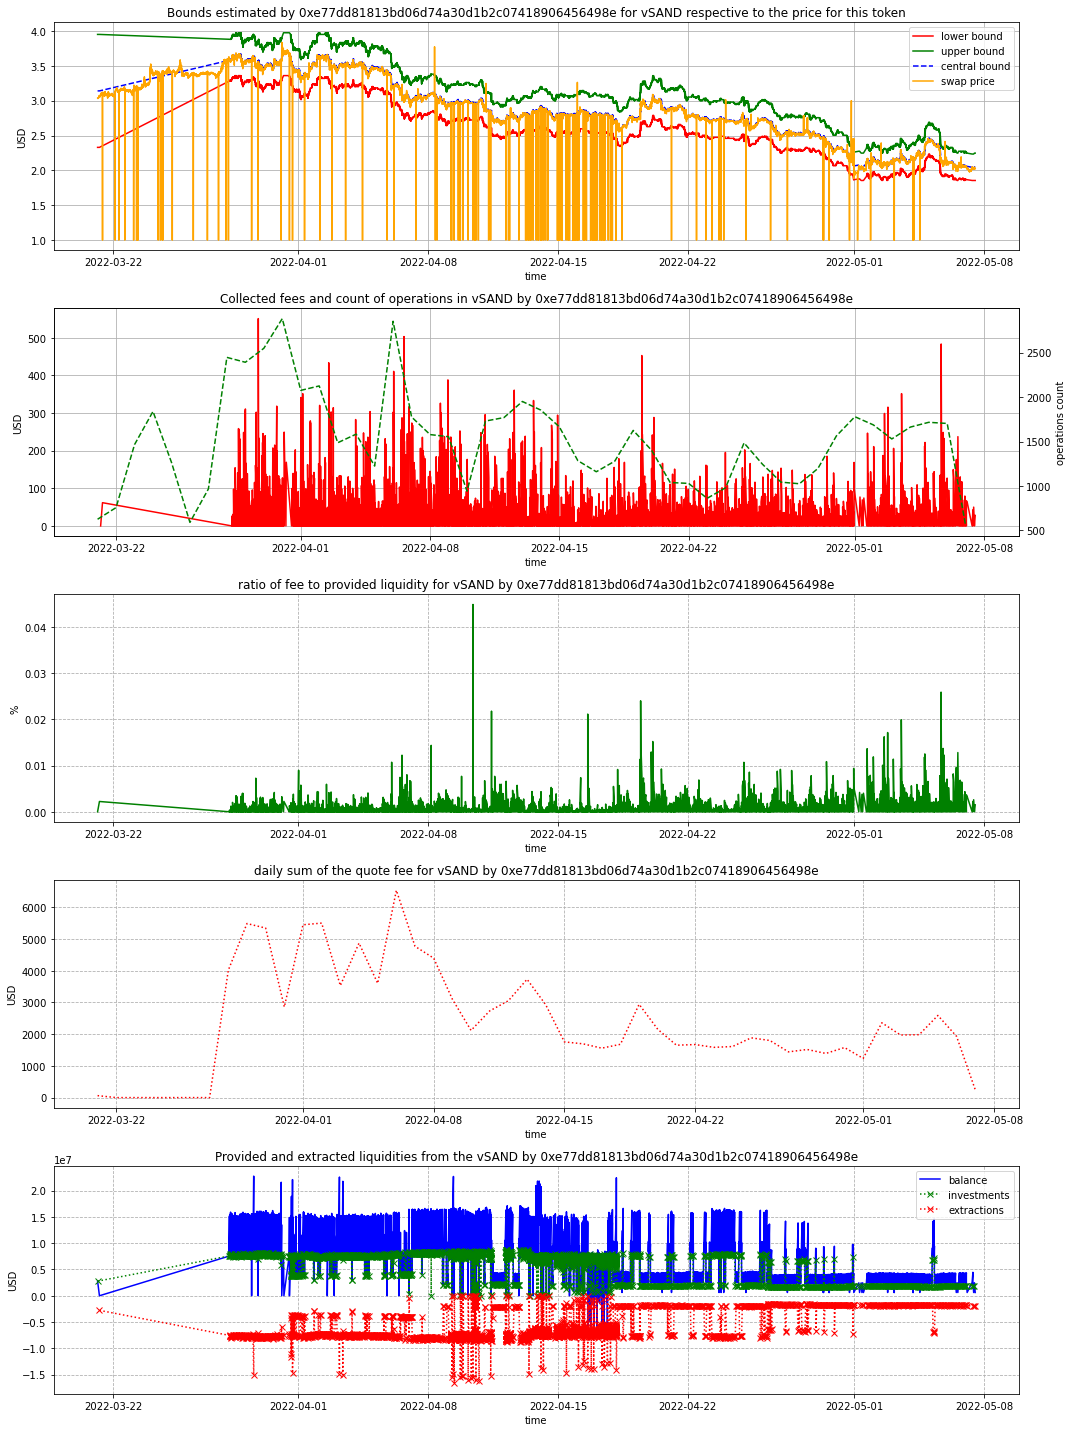

In [371]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0xe77dd81813bd06d74a30d1b2c07418906456498e",
                               pool_name="vSAND")

In [372]:
(1 + 0.01 / 100)**(24*365) 

2.401170202551435

## Checking first possible attack

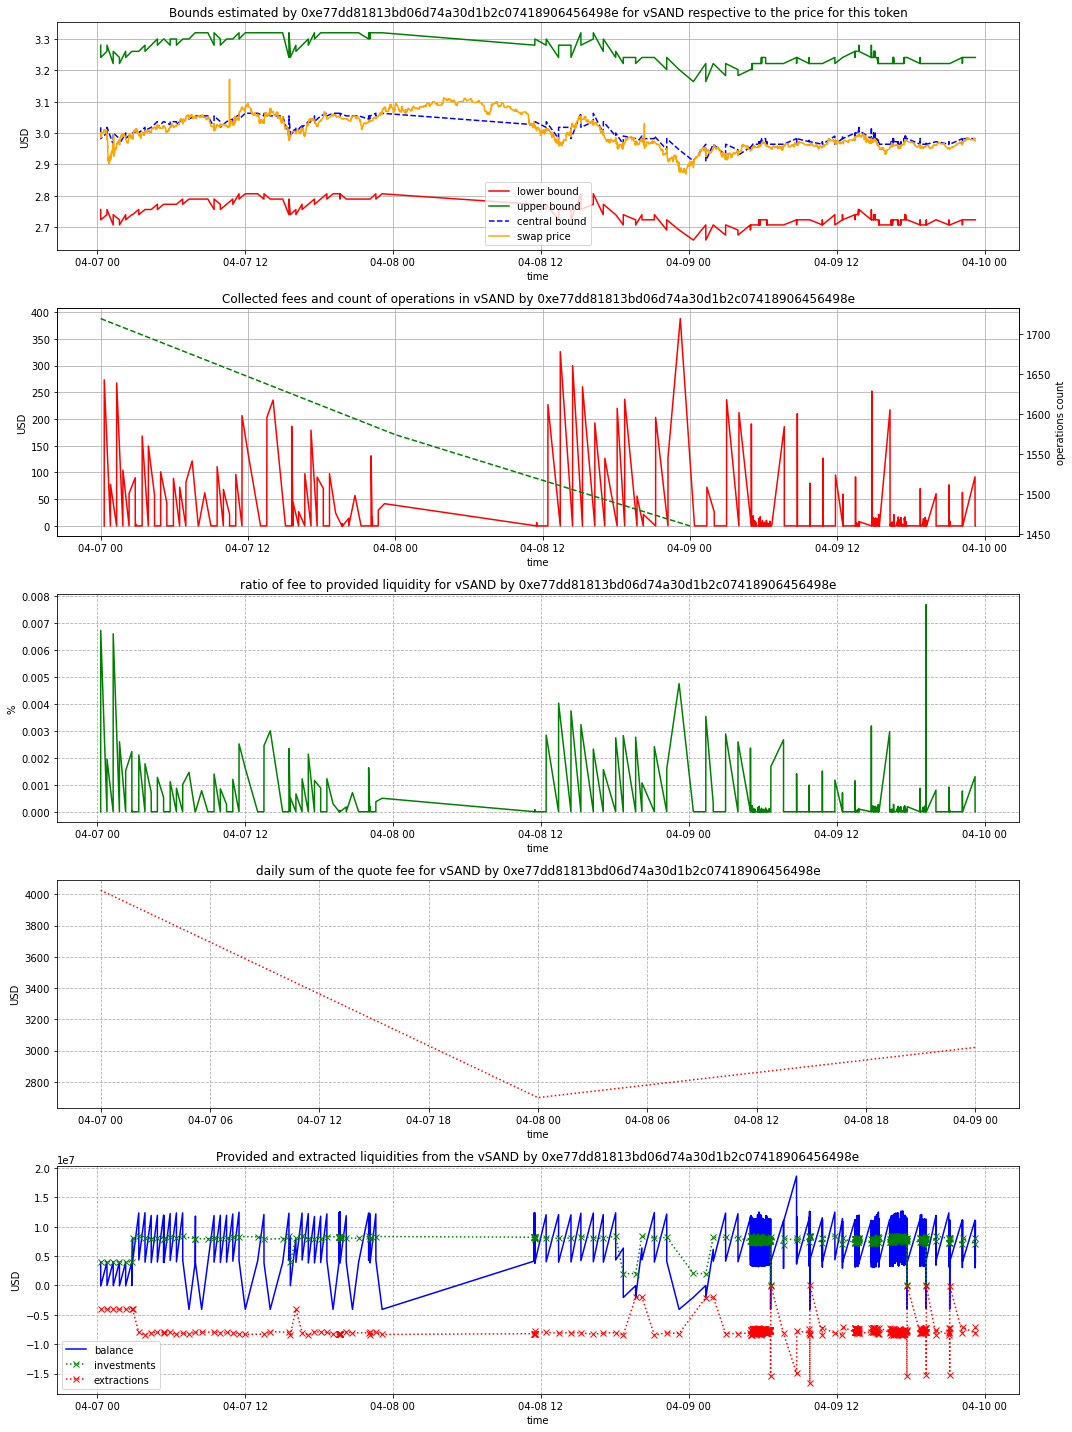

In [373]:
liquidity_maker_individual_flow(liquidity_changes_df[(liquidity_changes_df["time"] <= datetime(2022, 4, 10)) &
                                                    (liquidity_changes_df["time"] >= datetime(2022, 4, 7))], 
                                position_changes_df[(position_changes_df["time"] <= datetime(2022, 4, 10)) &
                                                    (position_changes_df["time"] >= datetime(2022, 4, 7))], 
                                maker="0xe77dd81813bd06d74a30d1b2c07418906456498e",
                               pool_name="vSAND")

## Checking the second possible attack

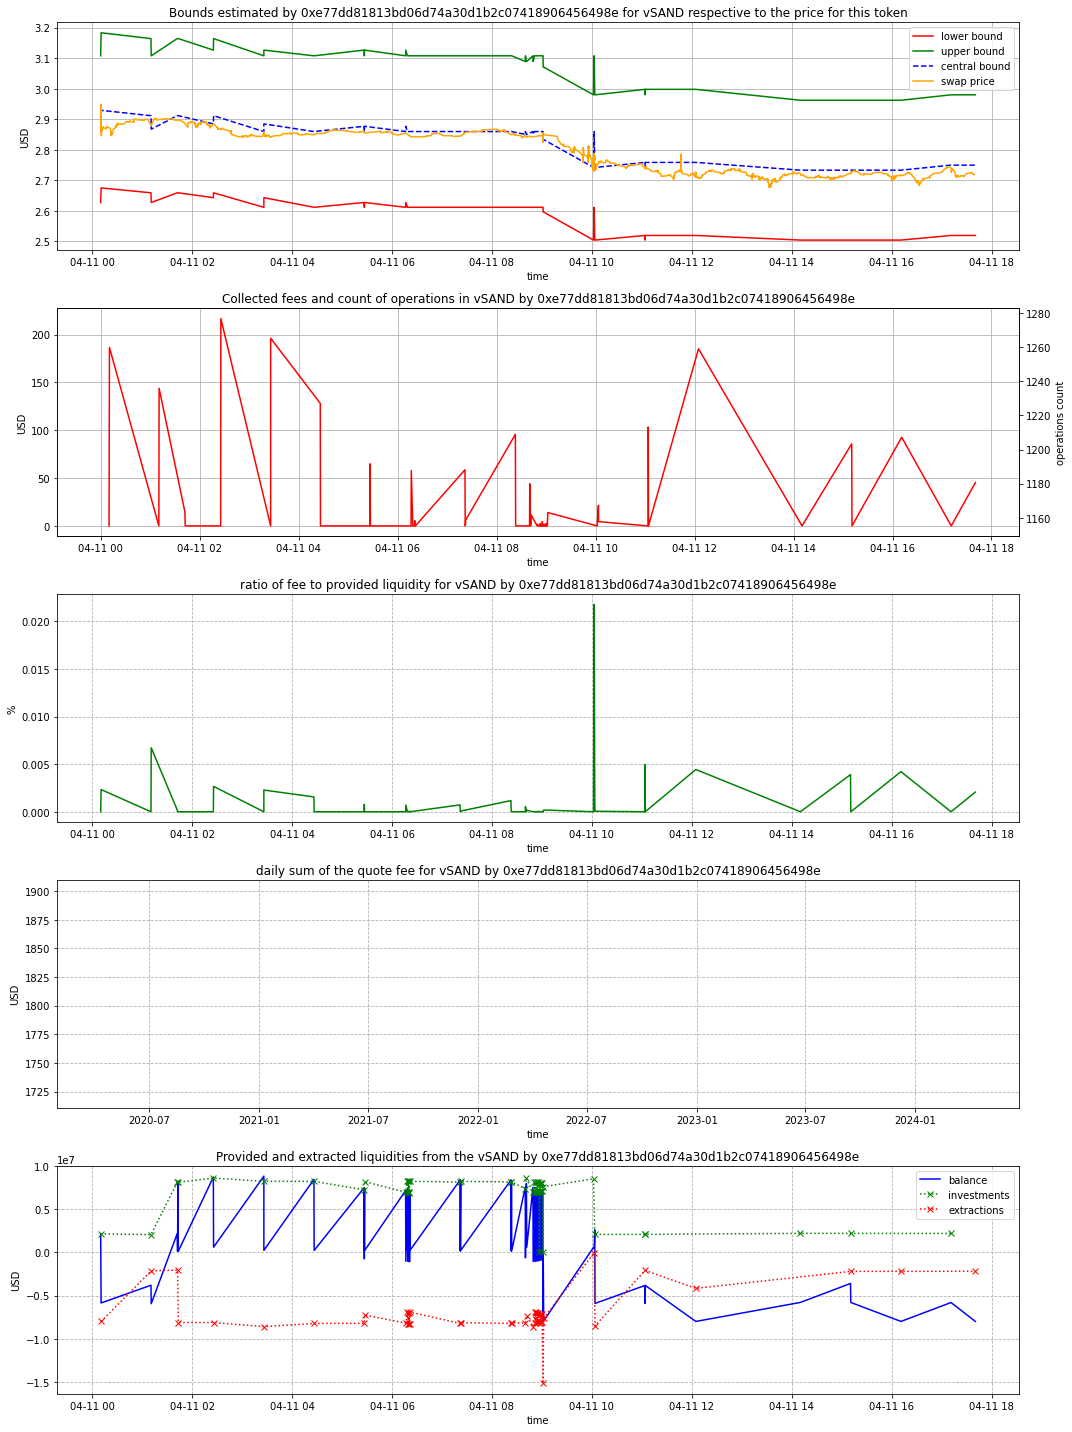

In [374]:
liquidity_maker_individual_flow(liquidity_changes_df[(liquidity_changes_df["time"] <= datetime(2022, 4, 12)) &
                                                    (liquidity_changes_df["time"] >= datetime(2022, 4, 11))], 
                                position_changes_df[(position_changes_df["time"] <= datetime(2022, 4, 12)) &
                                                    (position_changes_df["time"] >= datetime(2022, 4, 11))], 
                                maker="0xe77dd81813bd06d74a30d1b2c07418906456498e",
                               pool_name="vSAND")

## Check of the third possible attack

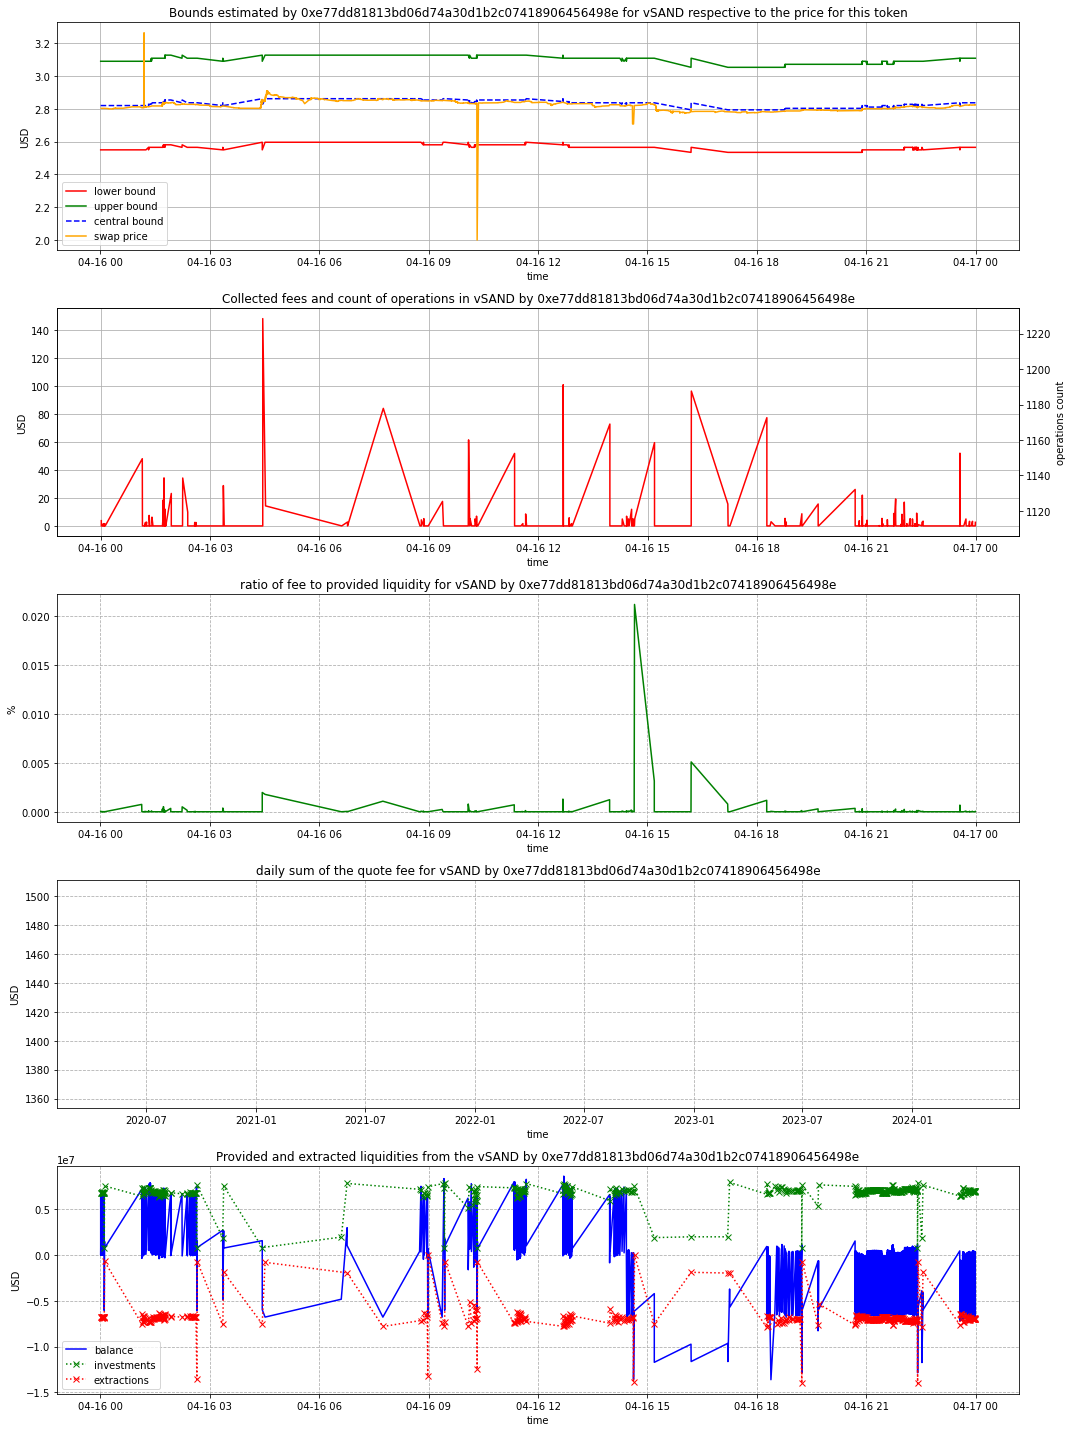

In [375]:
liquidity_maker_individual_flow(liquidity_changes_df[(liquidity_changes_df["time"] <= datetime(2022, 4, 17)) &
                                                    (liquidity_changes_df["time"] >= datetime(2022, 4, 16))], 
                                position_changes_df[(position_changes_df["time"] <= datetime(2022, 4, 17)) &
                                                    (position_changes_df["time"] >= datetime(2022, 4, 16))], 
                                maker="0xe77dd81813bd06d74a30d1b2c07418906456498e",
                               pool_name="vSAND")

# NEAR

## Check of the overall distribution

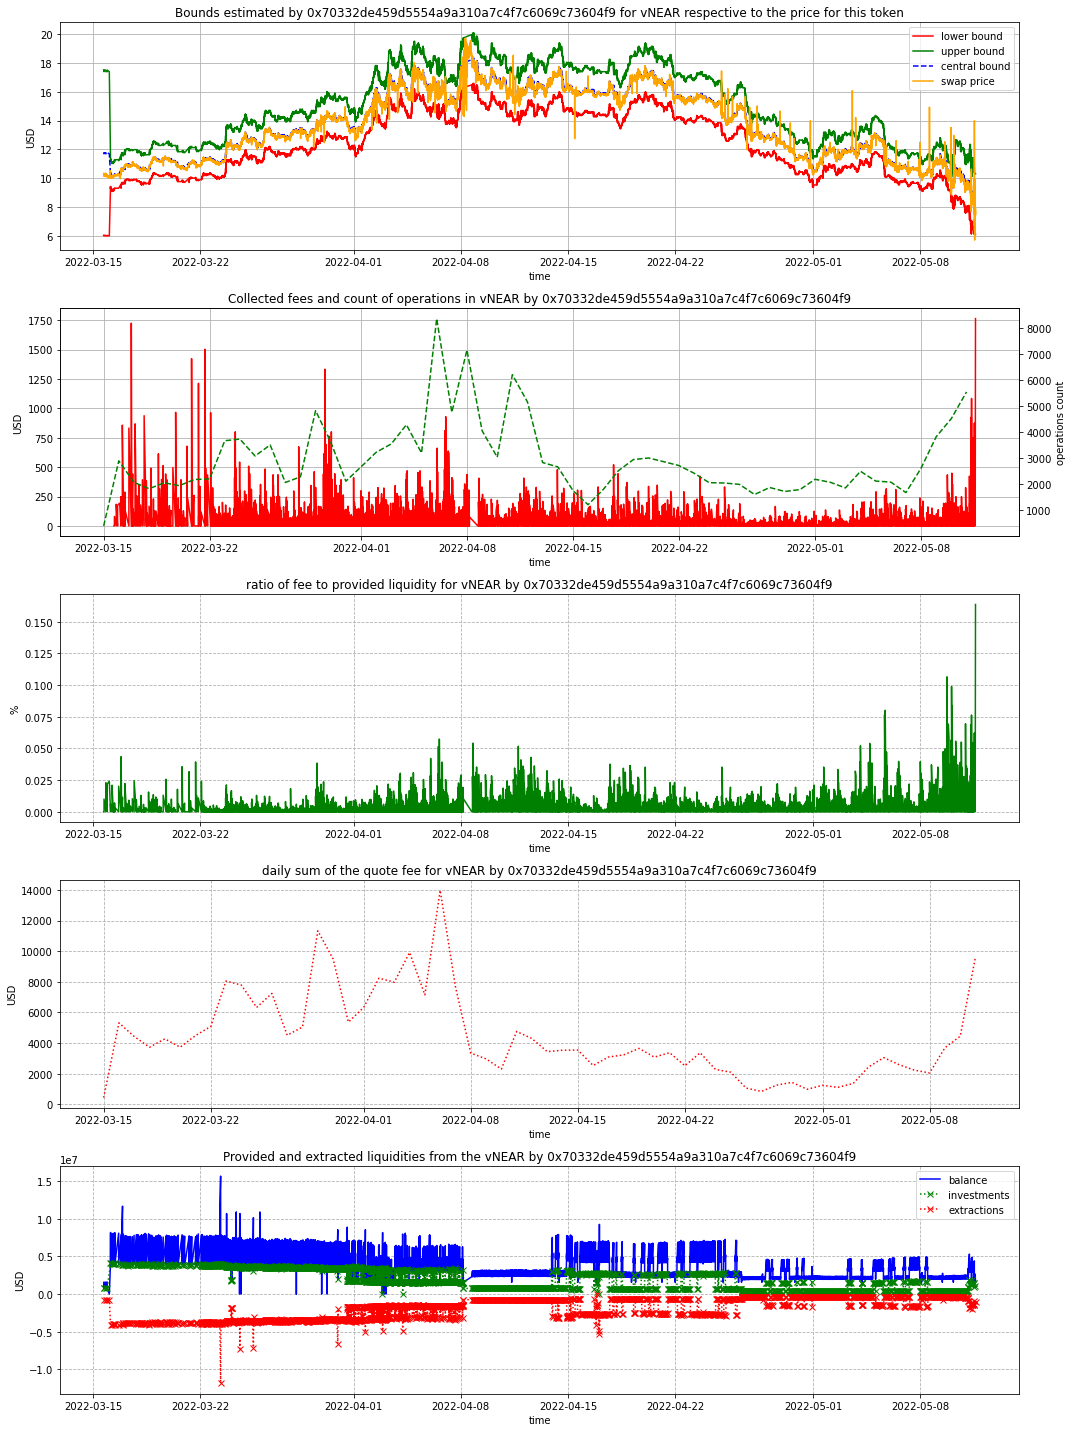

In [376]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x70332de459d5554a9a310a7c4f7c6069c73604f9",
                               pool_name="vNEAR")

## Check of the first possible attack

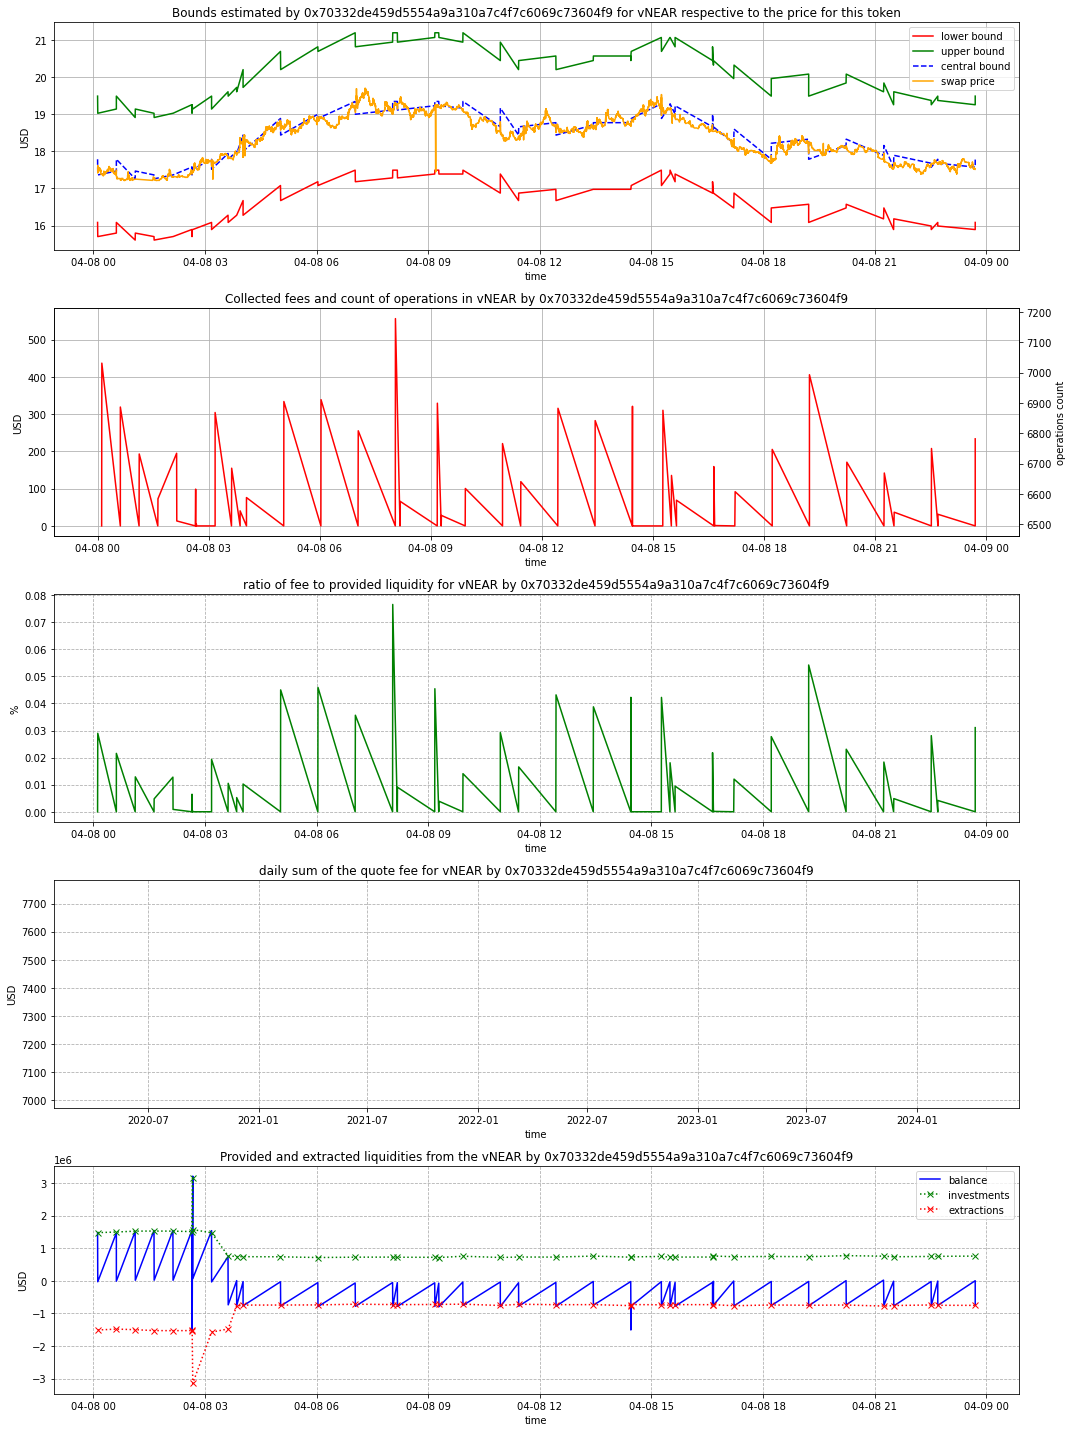

In [377]:
liquidity_maker_individual_flow(liquidity_changes_df[(liquidity_changes_df["time"] <= datetime(2022, 4, 9)) &
                                                    (liquidity_changes_df["time"] >= datetime(2022, 4, 8))], 
                                position_changes_df[(position_changes_df["time"] <= datetime(2022, 4, 9)) &
                                                   (position_changes_df["time"] >= datetime(2022, 4, 8))], 
                                maker="0x70332de459d5554a9a310a7c4f7c6069c73604f9",
                               pool_name="vNEAR")

## Check of the second possible attack

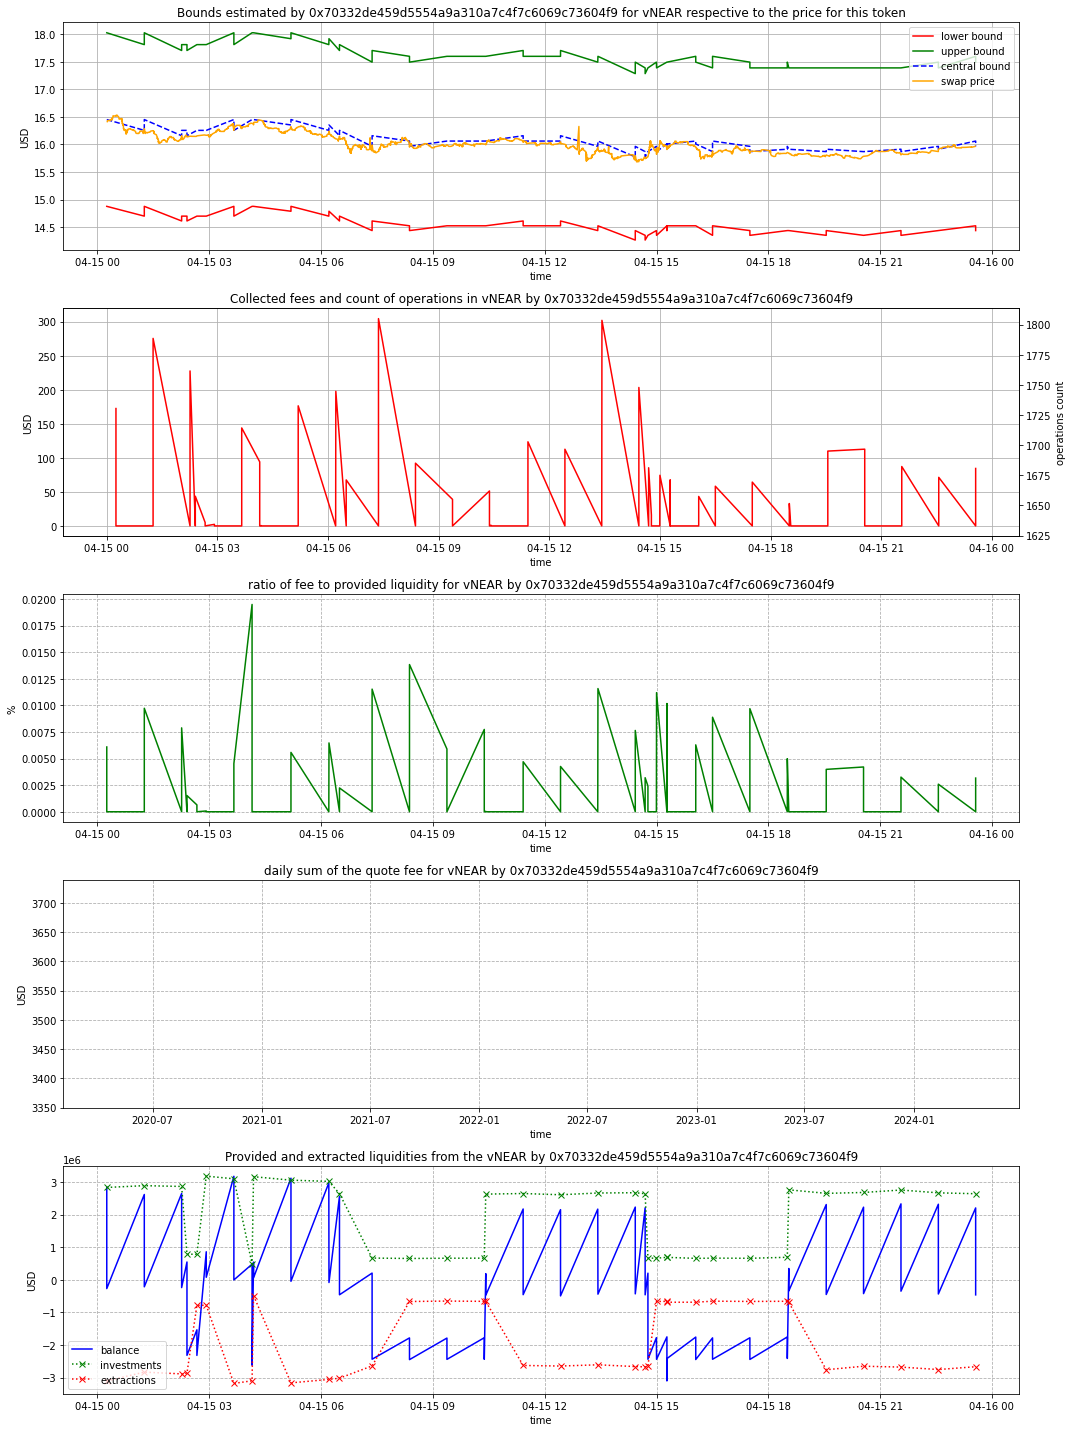

In [378]:
liquidity_maker_individual_flow(liquidity_changes_df[(liquidity_changes_df["time"] <= datetime(2022, 4, 16)) &
                                                    (liquidity_changes_df["time"] >= datetime(2022, 4, 15))], 
                                position_changes_df[(position_changes_df["time"] <= datetime(2022, 4, 16)) &
                                                   (position_changes_df["time"] >= datetime(2022, 4, 15))], 
                                maker="0x70332de459d5554a9a310a7c4f7c6069c73604f9",
                               pool_name="vNEAR")

# vFTM

## Check of the general distribution

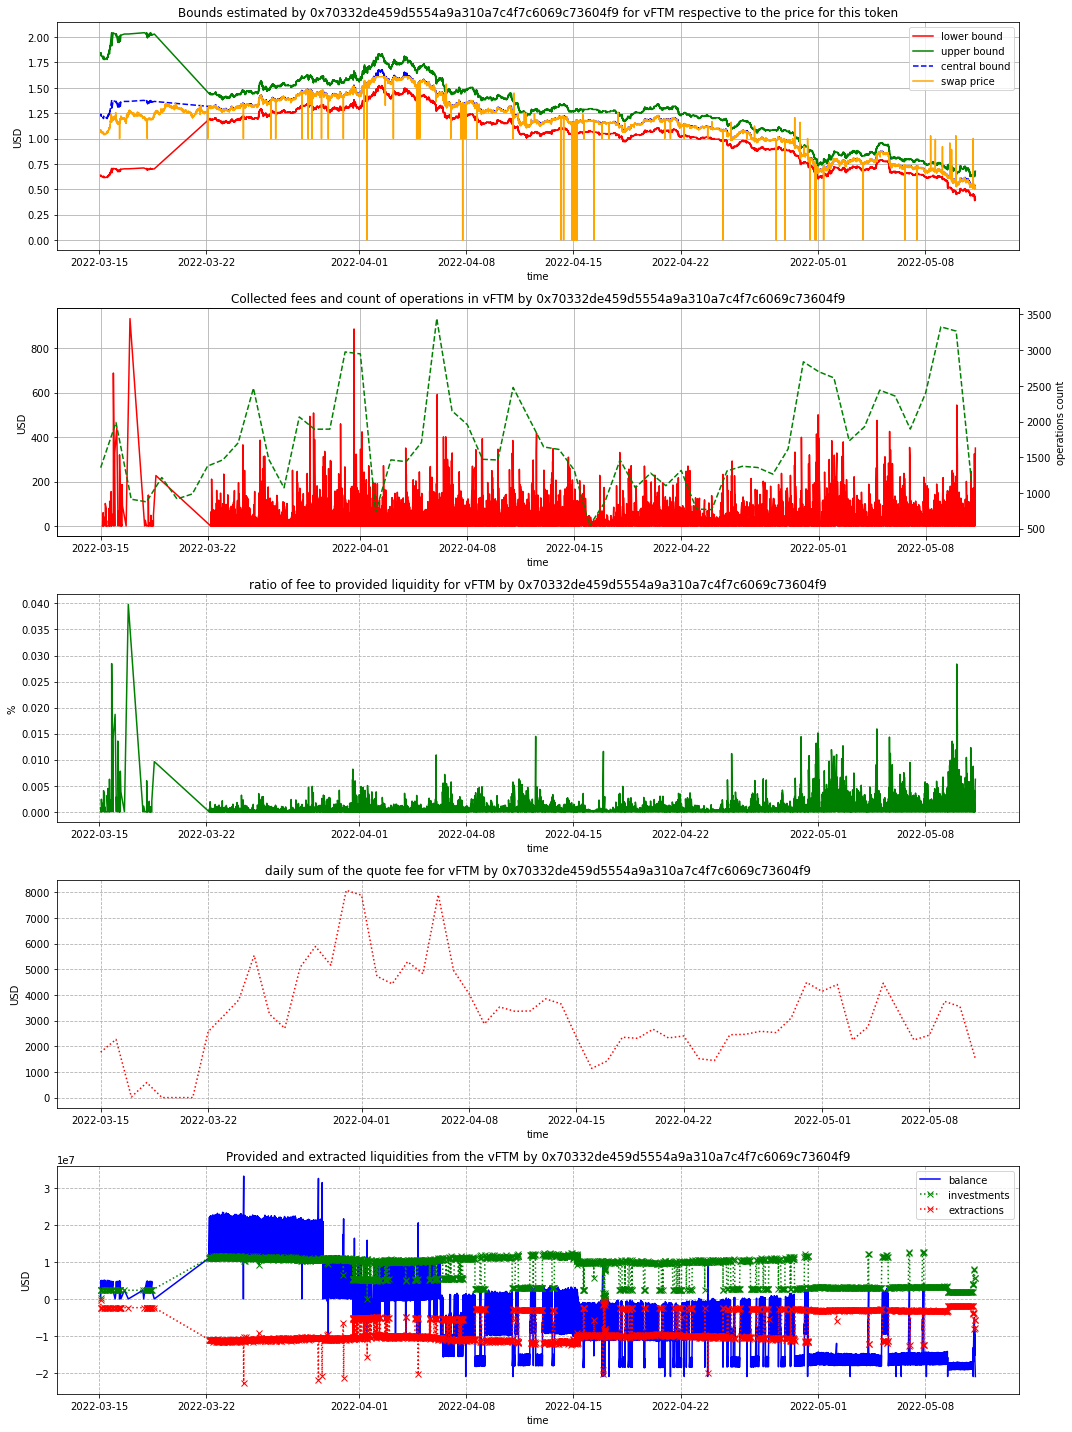

In [379]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x70332de459d5554a9a310a7c4f7c6069c73604f9",
                               pool_name="vFTM")

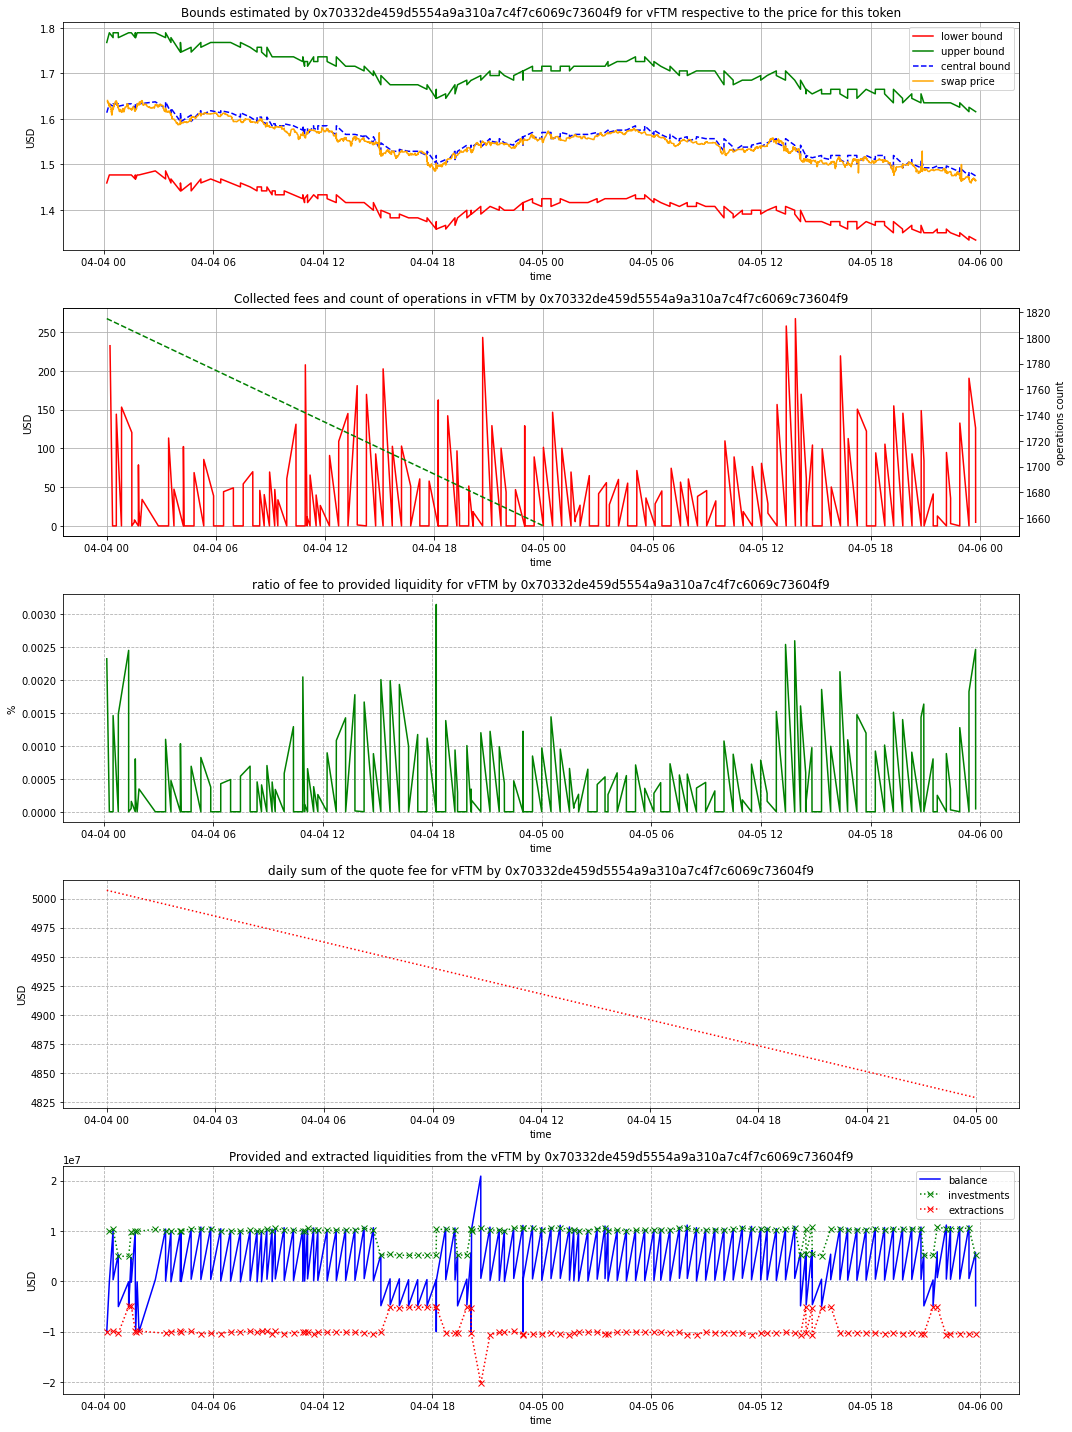

In [380]:
liquidity_maker_individual_flow(liquidity_changes_df[(liquidity_changes_df["time"] <= datetime(2022, 4, 6)) &
                                                    (liquidity_changes_df["time"] >= datetime(2022, 4, 4))], 
                                position_changes_df[(position_changes_df["time"] <= datetime(2022, 4, 6)) &
                                                   (position_changes_df["time"] >= datetime(2022, 4, 4))], 
                                maker="0x70332de459d5554a9a310a7c4f7c6069c73604f9",
                               pool_name="vFTM")

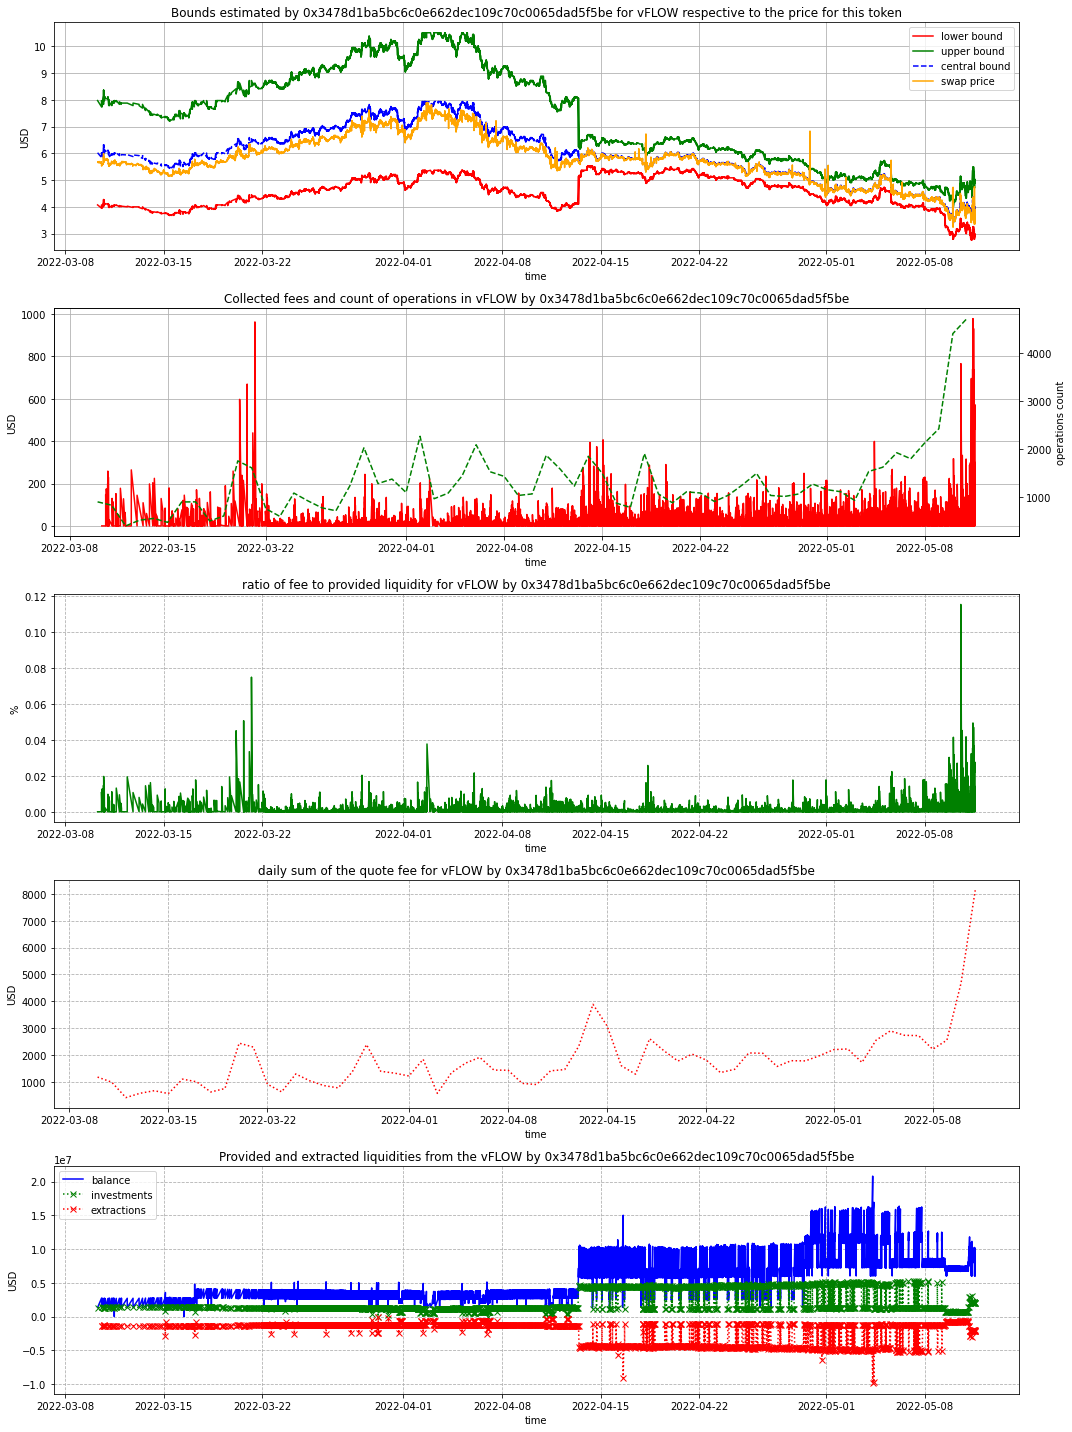

In [381]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be",
                               pool_name="vFLOW")

# LUNA

## Check of the general distribution

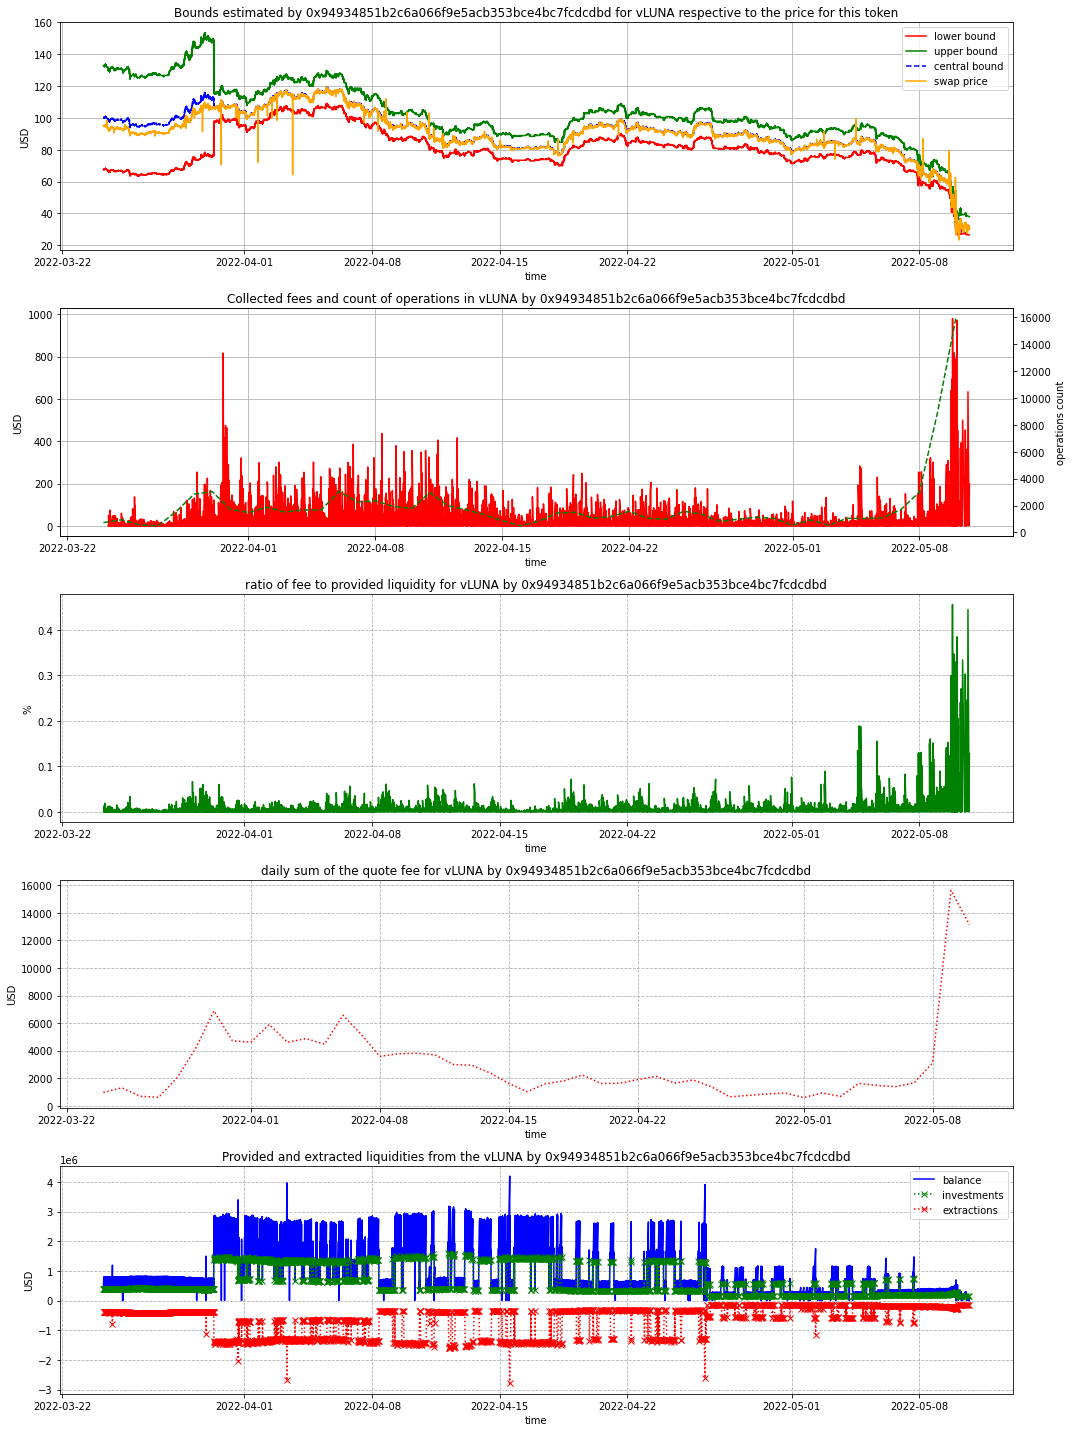

In [382]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd",
                               pool_name="vLUNA")

## Check of the first possible attack

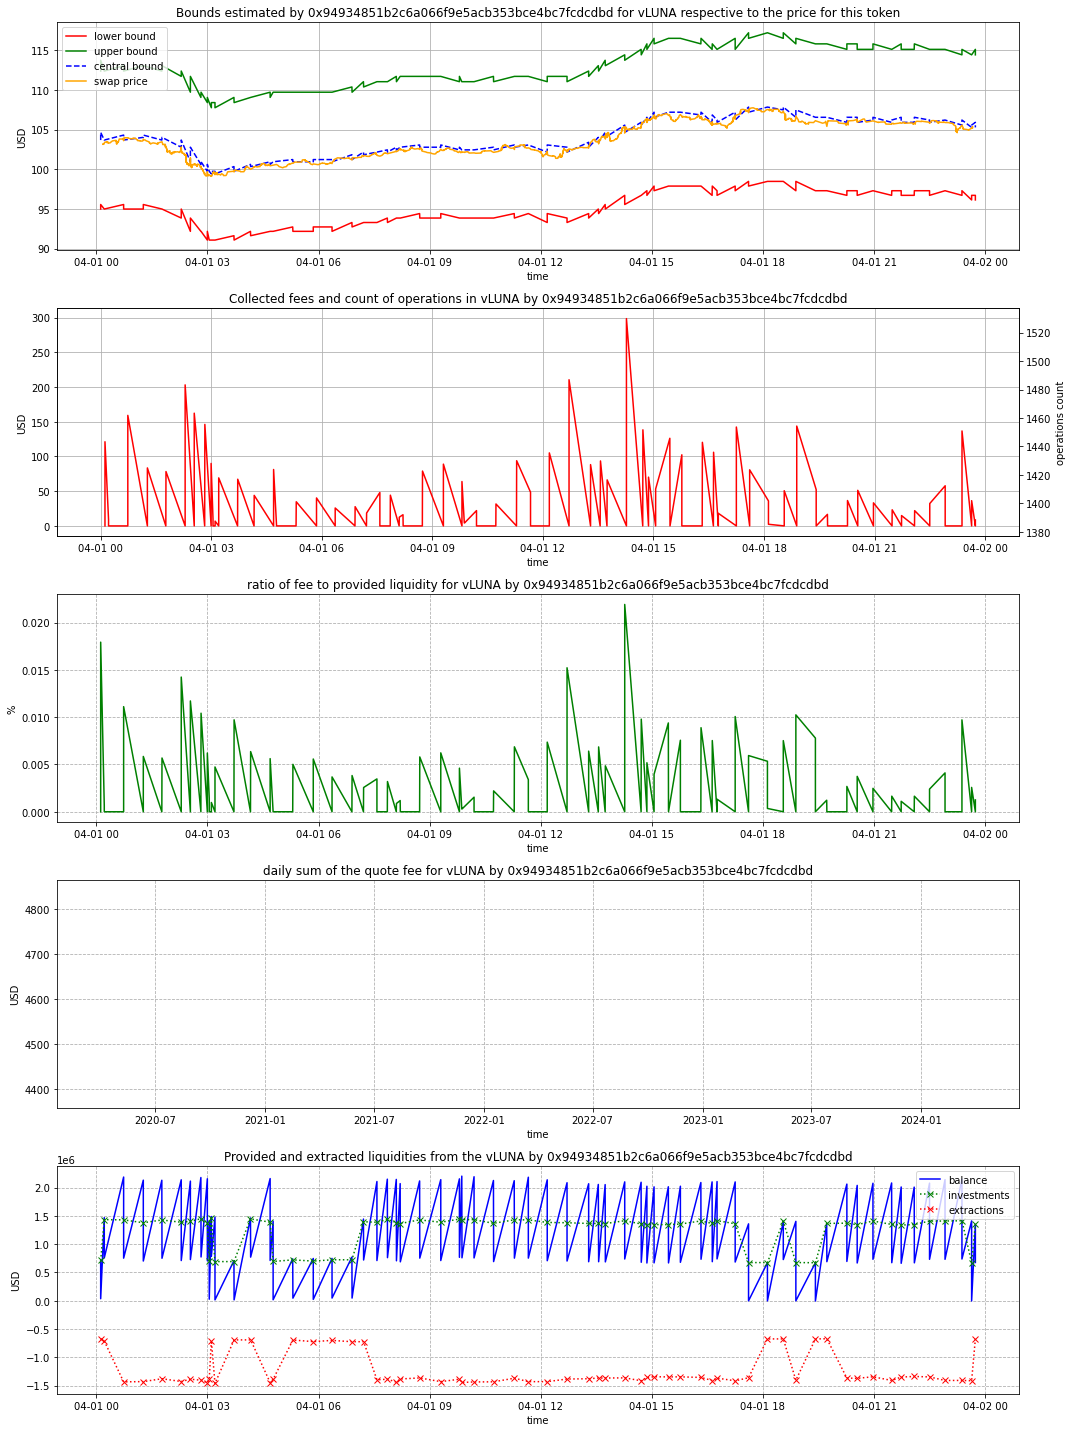

In [383]:
liquidity_maker_individual_flow(liquidity_changes_df[(liquidity_changes_df["time"] >= datetime(2022, 4, 1)) &
                                                    (liquidity_changes_df["time"] <= datetime(2022, 4, 2))], 
                                position_changes_df[(position_changes_df["time"] >= datetime(2022, 4, 1)) &
                                                   (position_changes_df["time"] <= datetime(2022, 4, 2))], 
                                maker="0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd",
                               pool_name="vLUNA")

# Writing script to detect anomalies

Considering that there is a need to find MEV attacks and perform their analysis considering problematic aspect of protecting transactions against them on the Perpetual it was decided to make a script that will catch all transactions with biggest price changes and therefore to perform a deeper analysis

In [384]:
position_changes_df.sort_values("block_number_log_index", inplace=True)
position_changes_df = position_changes_df.reset_index()
position_changes_df.drop(columns=["index", "day_of_year", "from_function_signature", "timestamp", "id", "block_number"], inplace=True)
position_changes_df

tx_hash  \
0        0x9a9ef69c82d19bde6a2794c5de22bbb02dd3b2b4f048...   
1        0x0e085ae4b7c345ee6de6d67f16c8c127a694d1c9f27f...   
2        0x8699da2d3dee9c704dbf13705c75524e618b2a83c8c3...   
3        0x548dd8a96b9faa92066283339832e380fd506f4ebc94...   
4        0x0ccfa4751250a5374b5d28823a1011987b833f71a1ce...   
...                                                    ...   
3180899  0x6006a805db9f443583373159d063e72f84821ec2061d...   
3180900  0x628a1b72d69ec32218bcf358261a4481ebf8540c28aa...   
3180901  0xf5d0c5fa6df841f7c48f923f388078f061b11961229d...   
3180902  0x93391319cd3cc71f8b43c2d1985ff3f39e5a3be22263...   
3180903  0x05c35f4c26d891ef2964257203b68074a1a2262f150d...   

                                             trader  exchanged_position_size  \
0        0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                 0.055178   
1        0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                 0.729828   
2        0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                 0.055138   
3        0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                 0.729264   
4        0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                 0.055098   
...                                             ...                      ...   
3180899  0x0136e94a86328c4a4108e51cf078b54314b6fbb0                 3.750372   
3180900  0x3c7c74a855b1eedd72c74c6cb3f2a55e7807575a              2189.882282   
3180901  0xfd7b219f946087dd75fbf3630bc674f347dafeee                 3.255000   
3180902  0xaeaba55e6f839946a94a8b651b44bd7ed66dc60b              2996.072718   
3180903  0xd7de65b79d01a94f8e0acc2c82c5520cc31bc927                26.180000   

         exchanged_position_notional       fee  open_notional  realized_pnl  \
0                       -2997.000000  3.000000   -3000.000000      0.000000   
1                       -2997.000000  3.000000   -3000.000000      0.000000   
2                       -2997.000000  3.000000   -6000.000000      0.000000   
3                       -2997.000000  3.000000   -6000.000000      0.000000   
4                       -2997.000000  3.000000   -9000.000000      0.000000   
...                              ...       ...            ...           ...   
3180899                  -834.052096  0.834887    4969.029001     10.700413   
3180900                 -1442.358383  1.443802    3963.386183     -0.899492   
3180901                 -3994.256861  3.998255   71979.008674    -10.243861   
3180902                 -1969.108458  1.971080    3098.198007     -3.060429   
3180903                 -1512.934286  1.514449   -9990.715682      0.000000   

         position_size_after  swapped_price  entry_price_after  \
0                   0.055178   54315.297418       54369.667085   
1                   0.729828    4106.445744        4110.556300   
2                   0.110316   54354.490389       54389.276112   
3                   1.459092    4109.624663        4112.146735   
4                   0.165414   54393.697496       54408.885139   
...                      ...            ...                ...   
3180899           -22.038770     222.391849         225.467624   
3180900         -6015.200622       0.658647           0.658895   
3180901           -58.749000    1227.114243        1225.195470   
3180902         -4716.634345       0.657230           0.656866   
3180903           171.870000      57.789698          58.129491   

         market_price_after  block_number_log_index                time  \
0              54334.893904               515560007 2021-11-27 08:19:00   
1               4108.035203               515571005 2021-11-27 08:19:00   
2              54374.093942               515582004 2021-11-27 08:19:00   
3               4111.214738               515584004 2021-11-27 08:19:00   
4              54413.308117               515587004 2021-11-27 08:19:00   
...                     ...                     ...                 ...   
3180899          222.577470             11544493008 2022-06-13 09:55:54   
318

In [385]:
indexes = {}
pct_threshold = 5

for pool in position_changes_df["pool_name"].unique():
    pool_position_changes = position_changes_df[position_changes_df["pool_name"] == pool]
    pool_position_changes["price_pct"] = pool_position_changes["swapped_price"].pct_change() * 100
    possible_mevs = np.array(pool_position_changes[abs(pool_position_changes["price_pct"]) >= pct_threshold].index)
    indexes[pool] = possible_mevs
    
indexes

{'vBTC': array([   3773,    3777,    6415,    6417,    6660,    6661,    7101,
           7104,    8182,    8184,    8981,    8982,   12125,   12126,
          14970,   14974,   15075,   15076,   17024,   17027,   19440,
          19445,   19967,   19971,   20167,   20172,   20577,   20579,
          21818,   21820,   34825,   34826,   38460,   38461,   38569,
          38581,   38917,   38919,   39521,   39526,   40709,   40720,
          50229,   50230,   50553,   50554,   50807,   50808,   52326,
          52338,   52535,   52536,   52604,   52605,   52679,   52688,
          52985,   54967,   54970,   56167,   56168,   56556,   56557,
          58806,   58813,   59288,   59290,   59853,   59854,   63197,
          63199,   63552,   63553,   63554,   63555,   63559,   63566,
          63608,   63610,   63612,   63613,   64369,   64370,   64391,
          64392,   64670,   64671,   64866,   64868,   64874,   64879,
          64883,   64887,   64916,   64917,   64933,   64935,   69728

Script above allows getting all possible mev attacks, it is required to see their plot. For example, below will be reviewed 4 pools: vBTC, vETH, vCRV, vPERP. Conform result of overall analysis can be seen that there are 3171 possible attacks.

In [386]:
overall_sum_attacks = 0
for pool in indexes.keys():
    overall_sum_attacks += len(indexes[pool])

overall_sum_attacks

10997

In [387]:
print(len(position_changes_df[position_changes_df["pool_name"] == 'vETH']))
print(len(position_changes_df[position_changes_df["pool_name"] == 'vBTC']))

279715
149222


2162 attacks in vETH


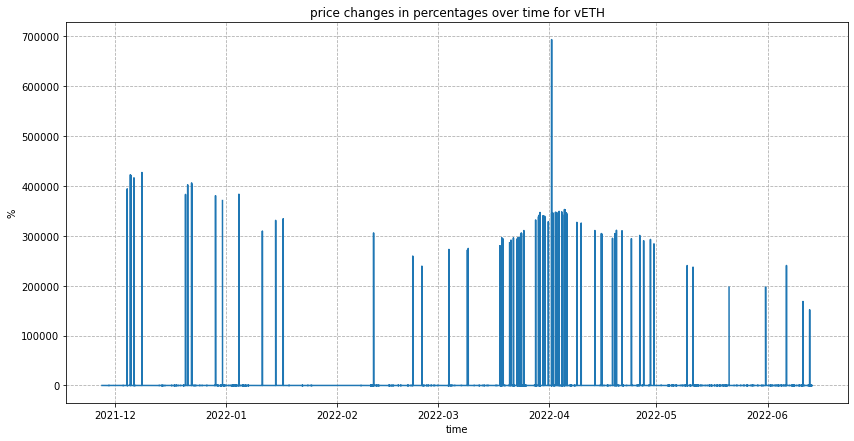

706 attacks in vBTC


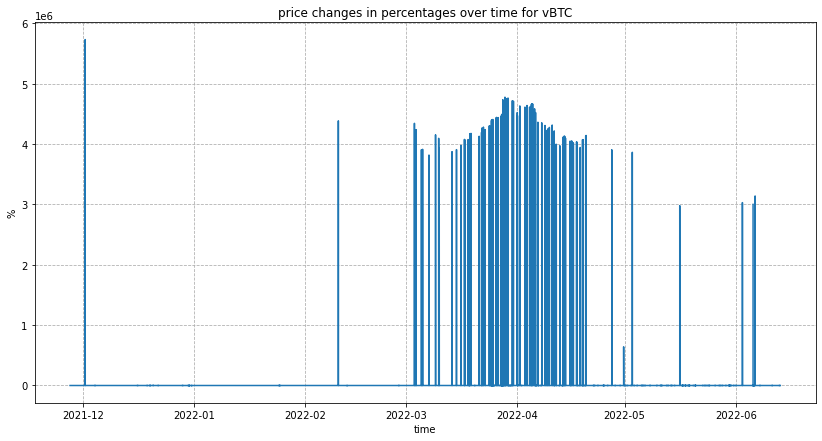

512 attacks in vPERP


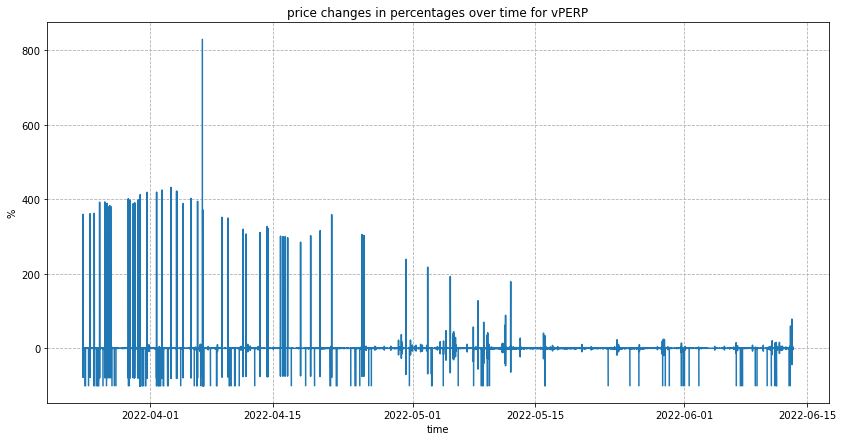

542 attacks in vCRV


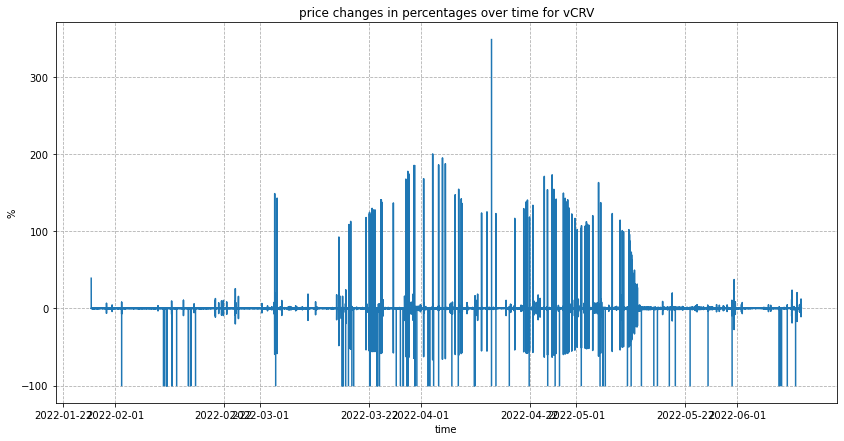

In [388]:
chosen_pools = ["vETH", "vBTC", "vPERP", "vCRV"]

for pool in chosen_pools:
    pool_position_changes = position_changes_df[position_changes_df["pool_name"] == pool]
    pool_position_changes["price_pct"] = pool_position_changes["swapped_price"].pct_change() * 100
    print(str(len(pool_position_changes[abs(pool_position_changes["price_pct"]) >= 5])) + " attacks in " + pool)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(pool_position_changes["time"], pool_position_changes["price_pct"])
    ax.set_xlabel("time")
    ax.set_ylabel("%")
    ax.set_title("price changes in percentages over time for " + pool)
    ax.grid(True, linestyle='--')
    plt.show()

In [389]:
pool_position_changes["price_pct"]

170923           NaN
170994     38.969549
170995      0.089144
170996      0.185272
171001      0.984432
             ...    
3180781     0.034471
3180846     0.282535
3180850     0.000000
3180897     0.013453
3180902     0.368903
Name: price_pct, Length: 232440, dtype: float64

                                 Pool vETH
median of the price change in % = 0.032362656794671096
standard deviation of the price change in % = 5770.9940091924
total amount of remaining attacks = 1627


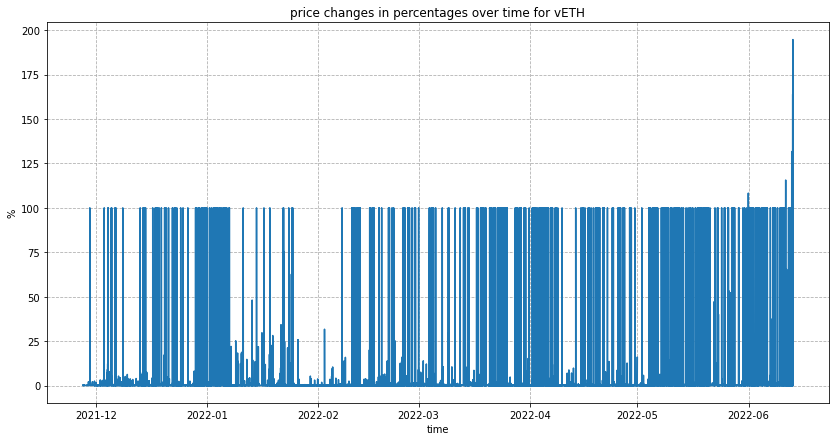

                                 Pool vBTC
median of the price change in % = 0.038007640547133015
standard deviation of the price change in % = 112450.59122658621
total amount of remaining attacks = 475


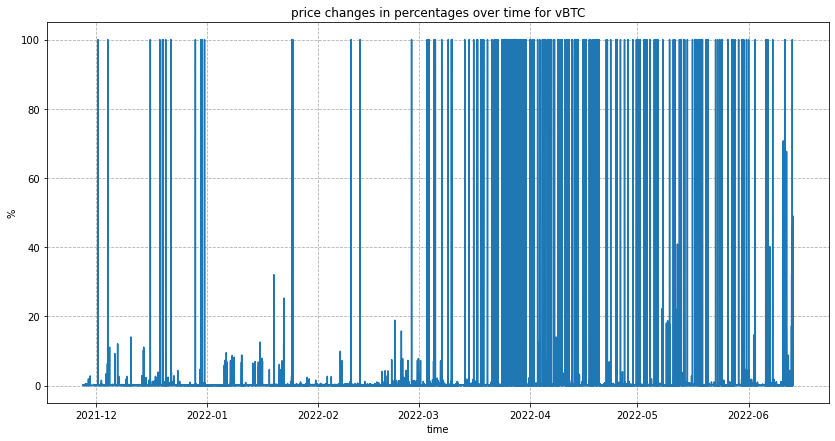

                                 Pool vPERP
median of the price change in % = 0.07472953961303874
standard deviation of the price change in % = 9.15121041219921
total amount of remaining attacks = 132


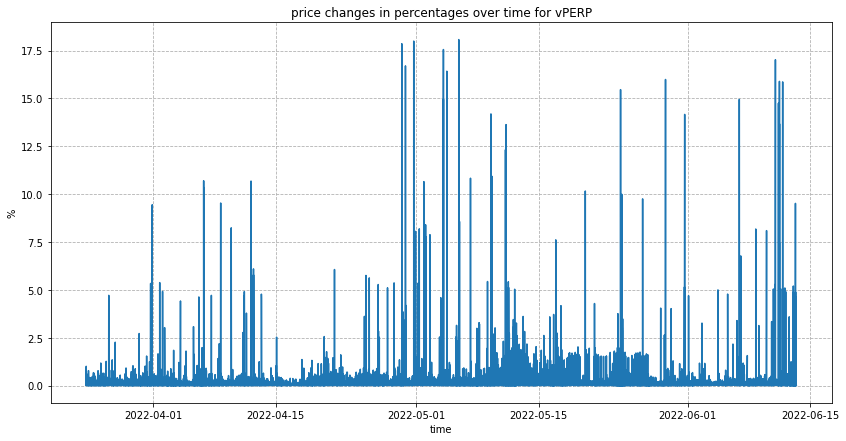

                                 Pool vCRV
median of the price change in % = 0.06781728599705161
standard deviation of the price change in % = 3.3988703764958776
total amount of remaining attacks = 53


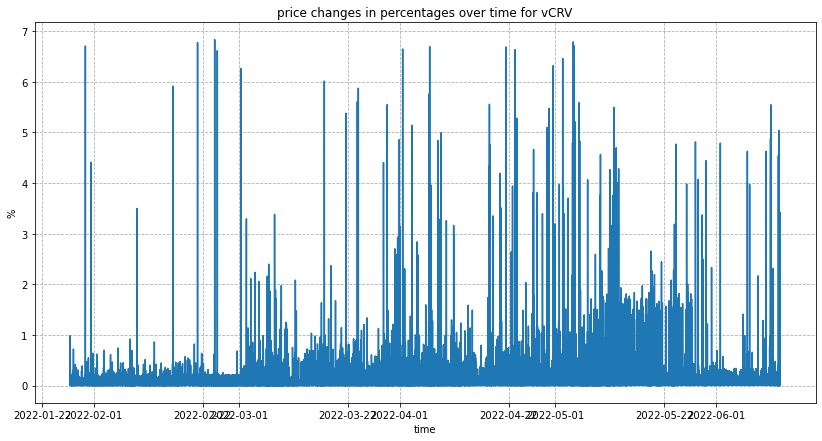

In [390]:
chosen_pools = ["vETH", "vBTC", "vPERP", "vCRV"]

for pool in chosen_pools:
    pool_position_changes = position_changes_df[position_changes_df["pool_name"] == pool]
    pool_position_changes["price_pct"] = abs(pool_position_changes["swapped_price"].pct_change(fill_method='ffill')) * 100
    # pool_position_changes = pool_position_changes.fillna(pool_position_changes["price_pct"].median())
    
    pool_position_changes = pool_position_changes[pool_position_changes["price_pct"] != np.inf]
    price_pct_median = pool_position_changes["price_pct"].median()
    price_pct_std = pool_position_changes["price_pct"].std()
    pool_position_changes = pool_position_changes[
        (pool_position_changes["price_pct"] <= (price_pct_median + (2 * price_pct_std))) &
        (pool_position_changes["price_pct"] >= (price_pct_median - (2 * price_pct_std)))
    ]
    
    print("                                 Pool " + pool)
    print("median of the price change in % = " + str(price_pct_median))
    print("standard deviation of the price change in % = " + str(price_pct_std))
    print("total amount of remaining attacks = " + str(len(pool_position_changes[
        abs(pool_position_changes["price_pct"]) >= 5])))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(pool_position_changes["time"], pool_position_changes["price_pct"])
    ax.set_xlabel("time")
    ax.set_ylabel("%")
    ax.set_title("price changes in percentages over time for " + pool)
    ax.grid(True, linestyle='--')
    plt.show()

There is one big problem with the data - because of the outliers size of standard deviation is too big. Also, filtering process will cause total ignorance of the unique cases, when price changes were so big that it caused anomalies and most likely covered some of the MEV attacks.

Another interesting aspect is that there are either extremely big changes in the data that go out too far from the distribution or covering up to 100% difference. Possible cause of this problem is of the internal errors in the Perpetual V2, when the price was covered incorrectly, it is required to check those moments.

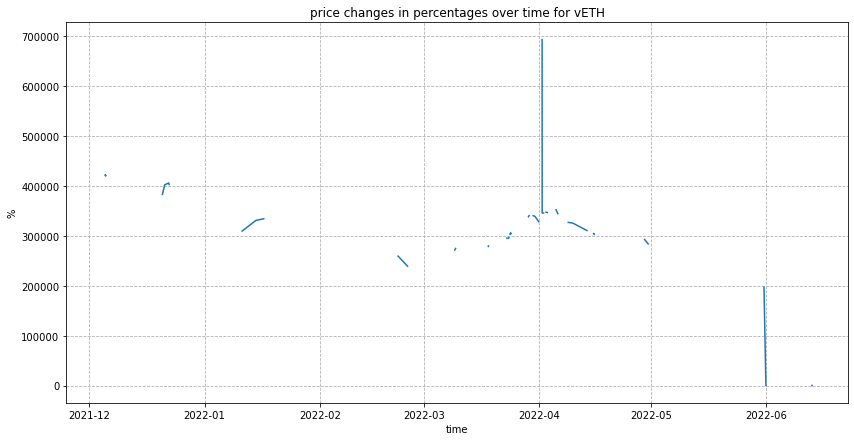

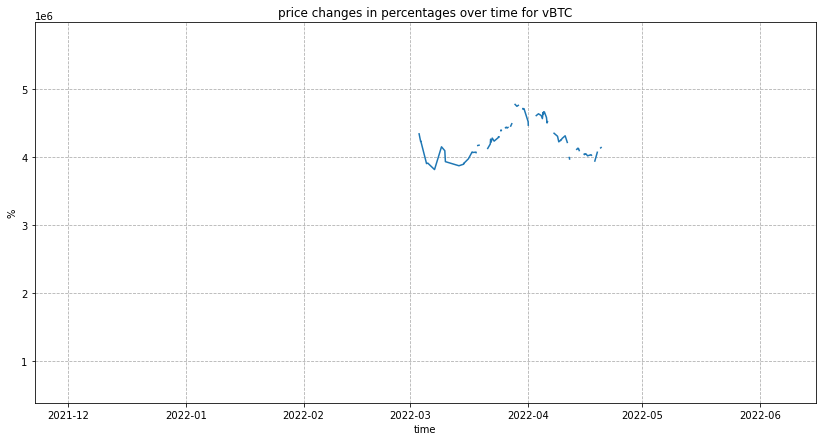

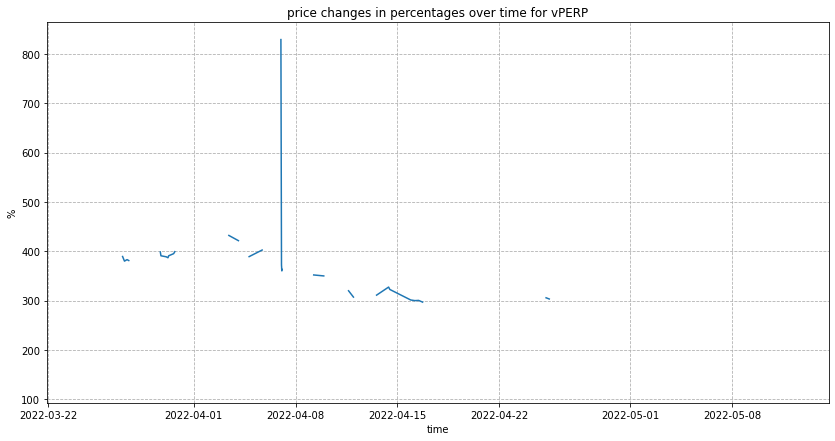

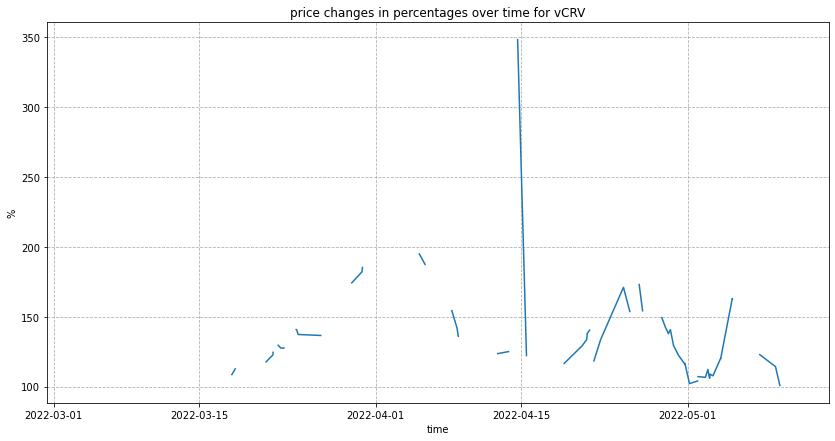

In [391]:
chosen_pools = ["vETH", "vBTC", "vPERP", "vCRV"]

for pool in chosen_pools:
    pool_position_changes = position_changes_df[position_changes_df["pool_name"] == pool]
    pool_position_changes["price_pct"] = abs(
        pool_position_changes["swapped_price"].pct_change(fill_method='ffill')
    ) * 100
    
    pool_position_changes = pool_position_changes[abs(pool_position_changes["price_pct"]) > 100]
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(pool_position_changes["time"], pool_position_changes["price_pct"])
    ax.set_xlabel("time")
    ax.set_ylabel("%")
    ax.set_title("price changes in percentages over time for " + pool)
    ax.grid(True, linestyle='--')
    plt.show()

Here is found a case of the broken transaction, because request of the transaction with strange price value demonstrated that while in the table is kept broken data, the real transaction values can be found on Optimism scanner

In [392]:
print(position_changes_df.loc[3770])

tx_hash                        0xd7573785e374f7a12edeabb012addb1ceda8e429ce60...
trader                                0x9c1e0c67aa30c063f341885b12cb81cc94613fc7
exchanged_position_size                                                -0.120186
exchanged_position_notional                                          6883.225972
fee                                                                     6.883226
open_notional                                                     -161766.195755
realized_pnl                                                          -13.444504
position_size_after                                                     2.821867
swapped_price                                                       57271.344962
entry_price_after                                                   57325.937562
market_price_after                                                  57259.353142
block_number_log_index                                                 652106005
time                        

In [393]:
print(position_changes_df.loc[3773]["tx_hash"])

0xc7bf6c6f08b5d943f82a70cb0aaafe05fe893c9fde3859778ccfbc9cdd69f26a


In [394]:
print(position_changes_df.loc[3777])

tx_hash                        0x425f5a8fe0ba9d90c1fd77bc6871013162ab80285309...
trader                                0x9c1e0c67aa30c063f341885b12cb81cc94613fc7
exchanged_position_size                                                 0.348727
exchanged_position_notional                                             -19980.0
fee                                                                         20.0
open_notional                                                     -181766.195755
realized_pnl                                                                 0.0
position_size_after                                                     3.170595
swapped_price                                                       57294.063769
entry_price_after                                                   57328.739793
market_price_after                                                  57328.783093
block_number_log_index                                                 652488007
time                        

In [395]:
position_changes_df[position_changes_df["exchanged_position_size"] == 0]

tx_hash  \
2254     0x1bfe9b500a4b5671425ef9f82a186f7b80f3d8e43833...   
3773     0xc7bf6c6f08b5d943f82a70cb0aaafe05fe893c9fde38...   
5307     0x8121eea61239a26bf1941317f96bec48c65391b6c8dc...   
6660     0xfc72217a47611c0403b8caa85ceae10aaa86e33eede1...   
6736     0x15a53766fc93da2518448dcc973fdaf0516e172cf42f...   
...                                                    ...   
3173921  0xe7b7cf7a3940322d048a8659f8b6f4c7f0dbcb2b270e...   
3175805  0xce24b4d5c0d4a5c931522f3a8f3aa3124ad6c6a1cbfd...   
3177237  0x8d0ff315b1e81e9a7319e253fe3d913caf703a947e4e...   
3177268  0x7c1f804a8ab2cb52425e319d50526df48a33235d44e8...   
3177628  0x7165a2749605005066f7391eab069997dfe8497cdc93...   

                                             trader  exchanged_position_size  \
2254     0xb3344d84ad8dd6b96301991bf12dc739e226c9cf                     -0.0   
3773     0xd102c01f146dd331f7b44b284c888b34e9e50b49                     -0.0   
5307     0x7c132bde28ad1e0101d45121757d7c6c2e8a550a                      0.0   
6660     0x7c132bde28ad1e0101d45121757d7c6c2e8a550a                      0.0   
6736     0x3b3b656a71ff2e322291b2fe305a3da5e1985159                     -0.0   
...                                             ...                      ...   
3173921  0x9b883c24574423f72936cc7519424bcb5ba0a4e9                     -0.0   
3175805  0x3c2be159678c6bc641a2852e2e6d95759a024241                     -0.0   
3177237  0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420                     -0.0   
3177268  0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420                     -0.0   
3177628  0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420                     -0.0   

         exchanged_position_notional  fee  open_notional  realized_pnl  \
2254                             0.0  0.0       0.000000           0.0   
3773                            -0.0  0.0       0.000000           0.0   
5307                             0.0  0.0       0.000000           0.0   
6660                             0.0  0.0       0.000000           0.0   
6736                            -0.0  0.0      51.984077           0.0   
...                              ...  ...            ...           ...   
3173921                          0.0  0.0       1.099491           0.0   
3175805                         -0.0  0.0 -319219.000335          -0.0   
3177237                          0.0  0.0       0.000000           0.0   
3177268                          0.0  0.0       0.000000           0.0   
3177628                          0.0  0.0       0.000000           0.0   

         position_size_after  swapped_price  entry_price_after  \
2254                0.000000            0.0           0.000000   
3773                0.000000            1.0           0.000000   
5307                0.000000            0.0           0.000000   
6660                0.000000            0.0           0.000000   
6736               -0.013329            1.0        3899.993443   
...                      ...            ...                ...   
3173921            -0.139382            0.0           7.888339   
3175805          8949.712924            1.0          35.668071   
3177237             0.000000            0.0           0.000000   
3177268             0.000000            0.0           0.000000   
3177628             0.000000            0.0           0.000000   

         market_price_after  block_number_log_index                time  \
2254            4368.773919               579610005 2021-11-29 07:04:08   
3773           57259.353142               652280006 2021-12-01 13:12:07   
5307            4582.051012               704107008 2021-12-03 07:28:43   
6660           47357.655492               752068008 2021-12-04 07:11:09   
6736            3939.358346               756483008 2021-12-04 09:06:39   
...                     ...                     ...                 ...   
3173921            3.569677             11518596009 2022-06-13 07:44:50   
3175805           27.394993             11524937006 2022-06-13 

In [396]:
position_changes_df[position_changes_df["trader"] == "0x7c132bde28ad1e0101d45121757d7c6c2e8a550a"]

tx_hash  \
5307   0x8121eea61239a26bf1941317f96bec48c65391b6c8dc...   
6660   0xfc72217a47611c0403b8caa85ceae10aaa86e33eede1...   
6771   0x2abd1bbe11a02cedc461d4474fb8d1d61ff8743b799b...   
7098   0x3b75fb934601dc9864ba08286572298537c72feed81d...   
7099   0x2d624b61279a7214a7f0d42c3350ebaf3d9e1f8f0717...   
...                                                  ...   
66418  0xc5e1a8f9654b62a3445e0133138cfd2640c5c4c428a6...   
66481  0x9fe9dd440f838dee0291dd1ec99d4485a768abfdac8a...   
66482  0xba1f774e638fab5e196e97911af3bfe66cf927b124d8...   
66483  0x050af8e198bec20ef383876c574aa21ac12151bd622d...   
66488  0x89e4399d1acd071eda57ddd6aac66c964dca5c762e56...   

                                           trader  exchanged_position_size  \
5307   0x7c132bde28ad1e0101d45121757d7c6c2e8a550a                 0.000000   
6660   0x7c132bde28ad1e0101d45121757d7c6c2e8a550a                 0.000000   
6771   0x7c132bde28ad1e0101d45121757d7c6c2e8a550a                 0.000000   
7098   0x7c132bde28ad1e0101d45121757d7c6c2e8a550a                -0.628057   
7099   0x7c132bde28ad1e0101d45121757d7c6c2e8a550a                 5.789124   
...                                           ...                      ...   
66418  0x7c132bde28ad1e0101d45121757d7c6c2e8a550a                -1.269315   
66481  0x7c132bde28ad1e0101d45121757d7c6c2e8a550a                 0.556002   
66482  0x7c132bde28ad1e0101d45121757d7c6c2e8a550a                 5.227348   
66483  0x7c132bde28ad1e0101d45121757d7c6c2e8a550a                -5.227348   
66488  0x7c132bde28ad1e0101d45121757d7c6c2e8a550a                -0.556002   

       exchanged_position_notional        fee  open_notional  realized_pnl  \
5307                      0.000000   0.000000       0.000000      0.000000   
6660                      0.000000   0.000000       0.000000      0.000000   
6771                      0.000000   0.000000       0.000000      0.000000   
7098                  30283.067971   0.000000   30283.067971      0.000000   
7099                 -25556.787317   0.000000  -25556.787317      0.000000   
...                            ...        ...            ...           ...   
66418                  4050.146537   4.050147       0.000000   -583.283622   
66481                -24349.351621   0.000000  -24349.351621      0.000000   
66482                -18076.995522   0.000000  -18076.995522      0.000000   
66483                 16536.792313  16.536792       0.000000  -1556.740000   
66488                 23269.343171  23.269343       0.000000  -1103.277793   

       position_size_after  swapped_price  entry_price_after  \
5307              0.000000       0.000000           0.000000   
6660              0.000000       0.000000           0.000000   
6771              0.000000       0.000000           0.000000   
7098             -0.628057   48217.091779       48217.091779   
7099              5.789124    4414.620603        4414.620603   
...                    ...            ...                ...   
66418             0.000000    3190.812441           0.000000   
66481             0.556002   43793.613763       43793.613763   
66482             5.227348    3458.158162        3458.158162   
66483             0.000000    3163.514825           0.000000   
66488             0.000000   41851.160690           0.000000   

       market_price_after  block_number_log_index                time  \
5307          4582.051012               704107008 2021-12-03 07:28:43   
6660         47357.655492               752068008 2021-12-04 07:11:09   
6771          3941.596141               758823006 2021-12-04 10:23:33   
7098         49092.124927               775797009 2021-12-04 19:16:18   
7099          4095.743375               775876006 2021-12-04 19:21:56   
...                   ...                     ...                 ...   
66418         3190.606752              2389852008 2022-01-18 06:06:03   
66481        41871.797147              2392507009 2022-01-18 08:32:47   
66482         3164.357870   

In [397]:
position_changes_df.loc[5307]["tx_hash"]

'0x8121eea61239a26bf1941317f96bec48c65391b6c8dc0946e6a1a3e52716d59a'

It is possible to remove all of those records that have strange data behavior and that could be restored using the web-scrapper written for getting data out of the "Etherscan-like" platforms.

As current solution, to ignore all moments with extreme price changes and to detect only real anomalies (or real possible attacks) it is required to perform filtering out of those values.

In [398]:
len(position_changes_df[(position_changes_df["exchanged_position_size"] == 0) &
                        (position_changes_df["exchanged_position_notional"] == 0) &
                        (position_changes_df["fee"] == 0) &
                        (position_changes_df["open_notional"] == 0) &
                        (position_changes_df["realized_pnl"] == 0) &
                        (position_changes_df["position_size_after"] == 0)]
)

1239

In [399]:
position_changes_df = position_changes_df.drop(position_changes_df[
    (position_changes_df["exchanged_position_size"] == 0) &
    (position_changes_df["exchanged_position_notional"] == 0) &
    (position_changes_df["fee"] == 0) &
    (position_changes_df["open_notional"] == 0) &
    (position_changes_df["realized_pnl"] == 0) &
    (position_changes_df["position_size_after"] == 0)
].index)

In [400]:
position_changes_df

tx_hash  \
0        0x9a9ef69c82d19bde6a2794c5de22bbb02dd3b2b4f048...   
1        0x0e085ae4b7c345ee6de6d67f16c8c127a694d1c9f27f...   
2        0x8699da2d3dee9c704dbf13705c75524e618b2a83c8c3...   
3        0x548dd8a96b9faa92066283339832e380fd506f4ebc94...   
4        0x0ccfa4751250a5374b5d28823a1011987b833f71a1ce...   
...                                                    ...   
3180899  0x6006a805db9f443583373159d063e72f84821ec2061d...   
3180900  0x628a1b72d69ec32218bcf358261a4481ebf8540c28aa...   
3180901  0xf5d0c5fa6df841f7c48f923f388078f061b11961229d...   
3180902  0x93391319cd3cc71f8b43c2d1985ff3f39e5a3be22263...   
3180903  0x05c35f4c26d891ef2964257203b68074a1a2262f150d...   

                                             trader  exchanged_position_size  \
0        0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                 0.055178   
1        0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                 0.729828   
2        0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                 0.055138   
3        0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                 0.729264   
4        0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                 0.055098   
...                                             ...                      ...   
3180899  0x0136e94a86328c4a4108e51cf078b54314b6fbb0                 3.750372   
3180900  0x3c7c74a855b1eedd72c74c6cb3f2a55e7807575a              2189.882282   
3180901  0xfd7b219f946087dd75fbf3630bc674f347dafeee                 3.255000   
3180902  0xaeaba55e6f839946a94a8b651b44bd7ed66dc60b              2996.072718   
3180903  0xd7de65b79d01a94f8e0acc2c82c5520cc31bc927                26.180000   

         exchanged_position_notional       fee  open_notional  realized_pnl  \
0                       -2997.000000  3.000000   -3000.000000      0.000000   
1                       -2997.000000  3.000000   -3000.000000      0.000000   
2                       -2997.000000  3.000000   -6000.000000      0.000000   
3                       -2997.000000  3.000000   -6000.000000      0.000000   
4                       -2997.000000  3.000000   -9000.000000      0.000000   
...                              ...       ...            ...           ...   
3180899                  -834.052096  0.834887    4969.029001     10.700413   
3180900                 -1442.358383  1.443802    3963.386183     -0.899492   
3180901                 -3994.256861  3.998255   71979.008674    -10.243861   
3180902                 -1969.108458  1.971080    3098.198007     -3.060429   
3180903                 -1512.934286  1.514449   -9990.715682      0.000000   

         position_size_after  swapped_price  entry_price_after  \
0                   0.055178   54315.297418       54369.667085   
1                   0.729828    4106.445744        4110.556300   
2                   0.110316   54354.490389       54389.276112   
3                   1.459092    4109.624663        4112.146735   
4                   0.165414   54393.697496       54408.885139   
...                      ...            ...                ...   
3180899           -22.038770     222.391849         225.467624   
3180900         -6015.200622       0.658647           0.658895   
3180901           -58.749000    1227.114243        1225.195470   
3180902         -4716.634345       0.657230           0.656866   
3180903           171.870000      57.789698          58.129491   

         market_price_after  block_number_log_index                time  \
0              54334.893904               515560007 2021-11-27 08:19:00   
1               4108.035203               515571005 2021-11-27 08:19:00   
2              54374.093942               515582004 2021-11-27 08:19:00   
3               4111.214738               515584004 2021-11-27 08:19:00   
4              54413.308117               515587004 2021-11-27 08:19:00   
...                     ...                     ...                 ...   
3180899          222.577470             11544493008 2022-06-13 09:55:54   
318

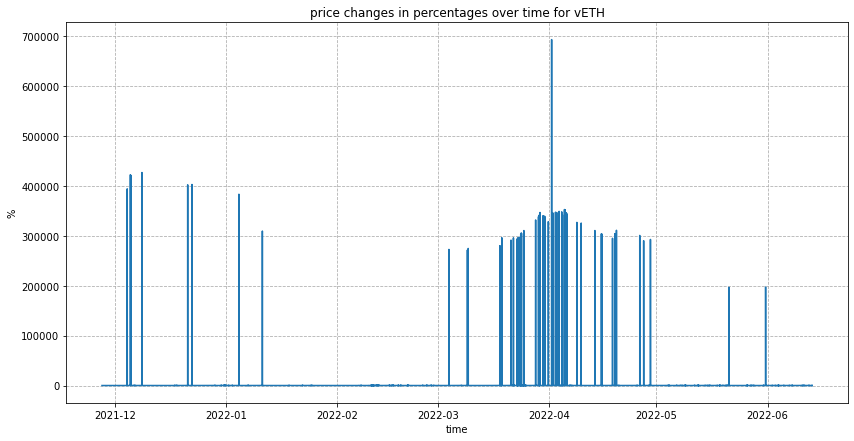

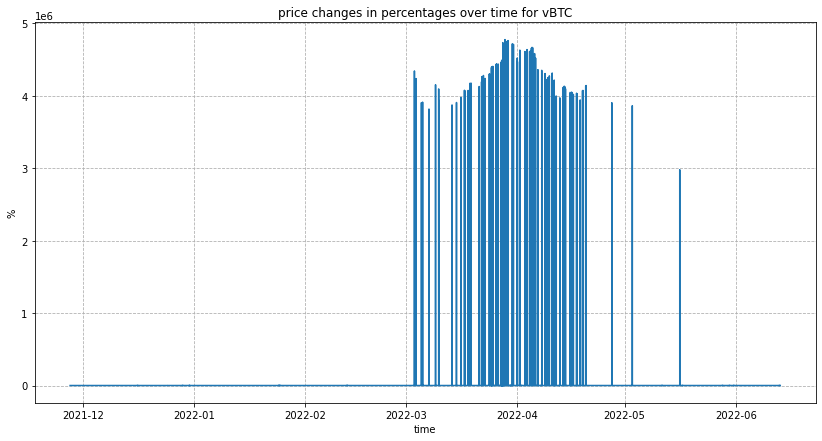

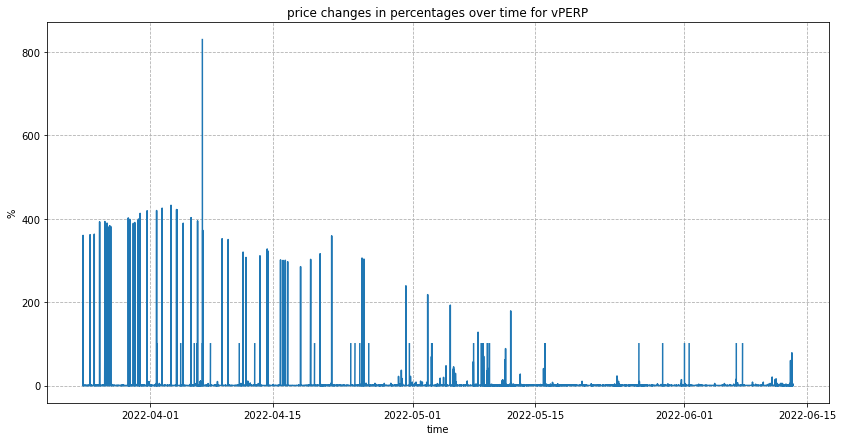

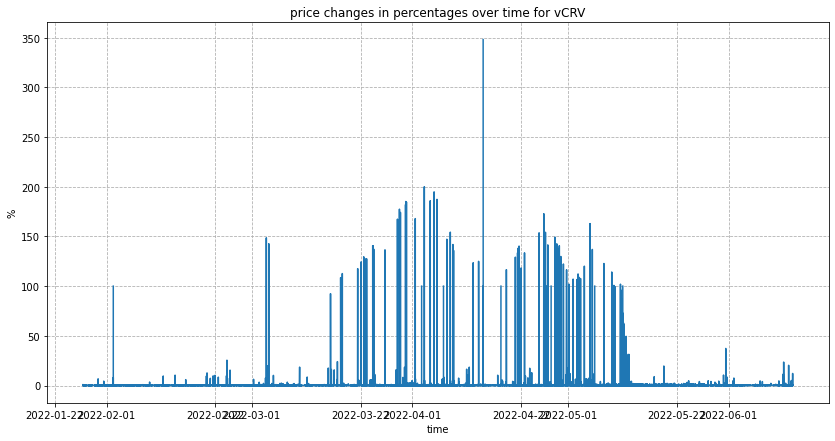

In [401]:
chosen_pools = ["vETH", "vBTC", "vPERP", "vCRV"]

for pool in chosen_pools:
    pool_position_changes = position_changes_df[position_changes_df["pool_name"] == pool]
    pool_position_changes["price_pct"] = abs(pool_position_changes["swapped_price"].pct_change(fill_method='ffill')) * 100
    # pool_position_changes = pool_position_changes.fillna(pool_position_changes["price_pct"].median())
    
    # pool_position_changes = pool_position_changes[pool_position_changes["price_pct"] != np.inf]
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(pool_position_changes["time"], pool_position_changes["price_pct"])
    ax.set_xlabel("time")
    ax.set_ylabel("%")
    ax.set_title("price changes in percentages over time for " + pool)
    ax.grid(True, linestyle='--')
    plt.show()

In [409]:
position_changes_df.loc[18610]["tx_hash"]

'0x355b9f4d9848f62951d1f8855ea4d49039b0b8a9aa9c958d51a65390ccd26bbd'

In [403]:
position_changes_df.loc[18621]

tx_hash                        0x6f5805f3b92a6fd832d77ca59fa4767378ff2f1051a8...
trader                                0x1d16ea2b8bfcf5f7c13c1ea792d6c6a7a9aa1063
exchanged_position_size                                                -3.100664
exchanged_position_notional                                         12012.012012
fee                                                                    12.012012
open_notional                                                            12000.0
realized_pnl                                                                 0.0
position_size_after                                                    -3.100664
swapped_price                                                        3874.013342
entry_price_after                                                    3870.139329
market_price_after                                                   3873.372599
block_number_log_index                                                1287153004
time                        

In [404]:
clear_position_changes = position_changes_df.drop(position_changes_df[
    (position_changes_df["exchanged_position_size"] == 0) &
    (position_changes_df["exchanged_position_notional"] == 0) &
    (position_changes_df["fee"] == 0)
].index)

clear_position_changes

tx_hash  \
0        0x9a9ef69c82d19bde6a2794c5de22bbb02dd3b2b4f048...   
1        0x0e085ae4b7c345ee6de6d67f16c8c127a694d1c9f27f...   
2        0x8699da2d3dee9c704dbf13705c75524e618b2a83c8c3...   
3        0x548dd8a96b9faa92066283339832e380fd506f4ebc94...   
4        0x0ccfa4751250a5374b5d28823a1011987b833f71a1ce...   
...                                                    ...   
3180899  0x6006a805db9f443583373159d063e72f84821ec2061d...   
3180900  0x628a1b72d69ec32218bcf358261a4481ebf8540c28aa...   
3180901  0xf5d0c5fa6df841f7c48f923f388078f061b11961229d...   
3180902  0x93391319cd3cc71f8b43c2d1985ff3f39e5a3be22263...   
3180903  0x05c35f4c26d891ef2964257203b68074a1a2262f150d...   

                                             trader  exchanged_position_size  \
0        0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                 0.055178   
1        0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                 0.729828   
2        0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                 0.055138   
3        0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                 0.729264   
4        0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                 0.055098   
...                                             ...                      ...   
3180899  0x0136e94a86328c4a4108e51cf078b54314b6fbb0                 3.750372   
3180900  0x3c7c74a855b1eedd72c74c6cb3f2a55e7807575a              2189.882282   
3180901  0xfd7b219f946087dd75fbf3630bc674f347dafeee                 3.255000   
3180902  0xaeaba55e6f839946a94a8b651b44bd7ed66dc60b              2996.072718   
3180903  0xd7de65b79d01a94f8e0acc2c82c5520cc31bc927                26.180000   

         exchanged_position_notional       fee  open_notional  realized_pnl  \
0                       -2997.000000  3.000000   -3000.000000      0.000000   
1                       -2997.000000  3.000000   -3000.000000      0.000000   
2                       -2997.000000  3.000000   -6000.000000      0.000000   
3                       -2997.000000  3.000000   -6000.000000      0.000000   
4                       -2997.000000  3.000000   -9000.000000      0.000000   
...                              ...       ...            ...           ...   
3180899                  -834.052096  0.834887    4969.029001     10.700413   
3180900                 -1442.358383  1.443802    3963.386183     -0.899492   
3180901                 -3994.256861  3.998255   71979.008674    -10.243861   
3180902                 -1969.108458  1.971080    3098.198007     -3.060429   
3180903                 -1512.934286  1.514449   -9990.715682      0.000000   

         position_size_after  swapped_price  entry_price_after  \
0                   0.055178   54315.297418       54369.667085   
1                   0.729828    4106.445744        4110.556300   
2                   0.110316   54354.490389       54389.276112   
3                   1.459092    4109.624663        4112.146735   
4                   0.165414   54393.697496       54408.885139   
...                      ...            ...                ...   
3180899           -22.038770     222.391849         225.467624   
3180900         -6015.200622       0.658647           0.658895   
3180901           -58.749000    1227.114243        1225.195470   
3180902         -4716.634345       0.657230           0.656866   
3180903           171.870000      57.789698          58.129491   

         market_price_after  block_number_log_index                time  \
0              54334.893904               515560007 2021-11-27 08:19:00   
1               4108.035203               515571005 2021-11-27 08:19:00   
2              54374.093942               515582004 2021-11-27 08:19:00   
3               4111.214738               515584004 2021-11-27 08:19:00   
4              54413.308117               515587004 2021-11-27 08:19:00   
...                     ...                     ...                 ...   
3180899          222.577470             11544493008 2022-06-13 09:55:54   
318

amount of possible attacks detected on the pool vETH is equal to 1102


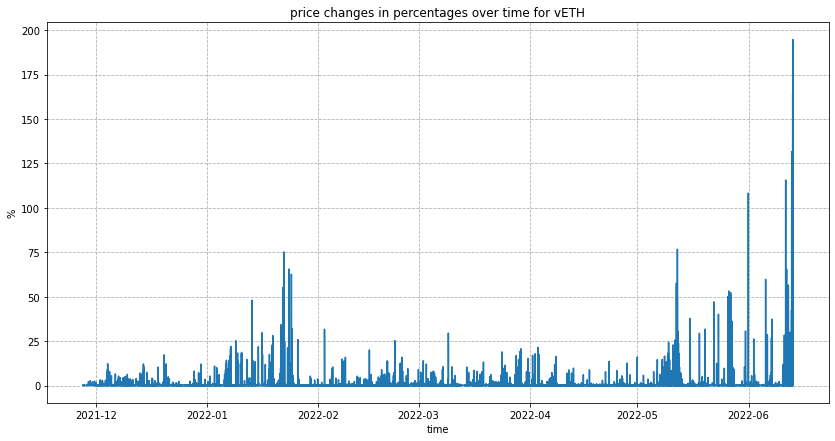

amount of possible attacks detected on the pool vBTC is equal to 248


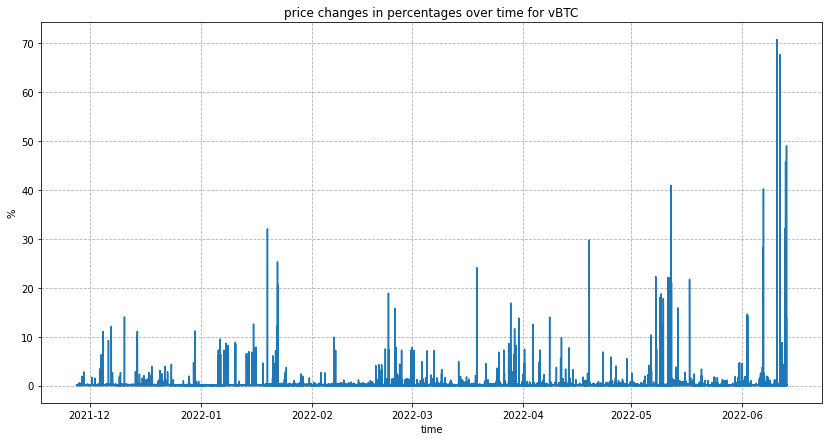

amount of possible attacks detected on the pool vPERP is equal to 166


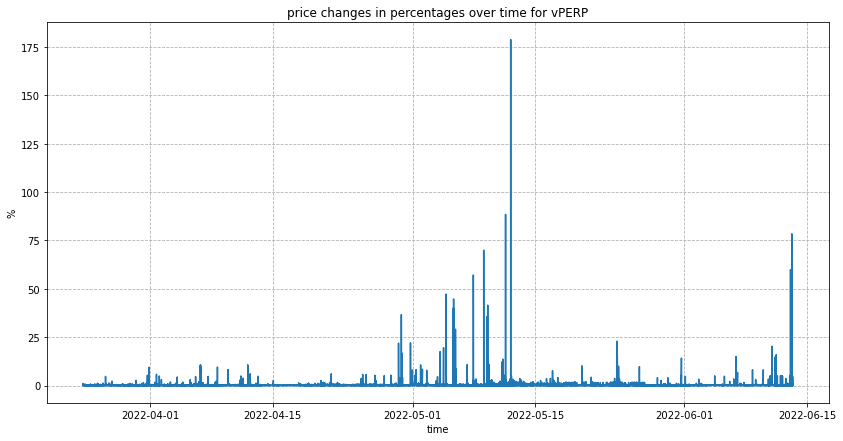

amount of possible attacks detected on the pool vCRV is equal to 204


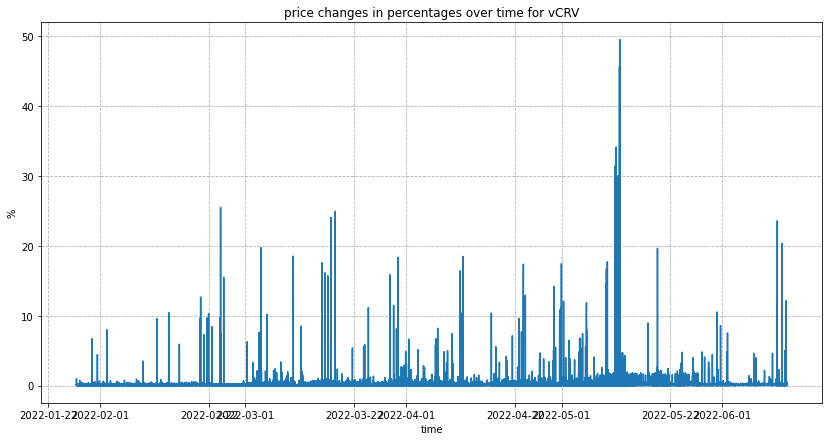

In [405]:
chosen_pools = ["vETH", "vBTC", "vPERP", "vCRV"]

for pool in chosen_pools:
    pool_position_changes = clear_position_changes[clear_position_changes["pool_name"] == pool]
    pool_position_changes["price_pct"] = abs(pool_position_changes["swapped_price"].pct_change(fill_method='ffill')) * 100
    
    print("amount of possible attacks detected on the pool " + pool + " is equal to " + 
          str(len(pool_position_changes[pool_position_changes["price_pct"] > 5])))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(pool_position_changes["time"], pool_position_changes["price_pct"])
    ax.set_xlabel("time")
    ax.set_ylabel("%")
    ax.set_title("price changes in percentages over time for " + pool)
    ax.grid(True, linestyle='--')
    plt.show()

In [406]:
overall_attacks_count = 0

for pool in clear_position_changes["pool_name"].unique():
    pool_position_changes = clear_position_changes[clear_position_changes["pool_name"] == pool]
    pool_position_changes["price_pct"] = abs(pool_position_changes["swapped_price"].pct_change(fill_method='ffill')) * 100
    
    overall_attacks_count += len(pool_position_changes[pool_position_changes["price_pct"] > 5])
    
print("overall attacks count is equal to " + str(overall_attacks_count))

overall attacks count is equal to 3748


In [407]:
len(clear_position_changes) - len(position_changes_df)

-4682

Out of the original around 3 000 000 records there are around 1 200 records with extreme data gaps, and 4 682 records with small gaps in data and strange structure, meaning that out of the 3 000 000 records there are only 3 748 cases of possible MEV attacks. Therefore it is required to write a script that will be able to catch up all of those cases.

Another important problem is that there is a need to choose an approach of how to deal with those strange transactions, because they will either call disturbances in the data and gaps, or there will be problem with lack of match between real data and collected one

In [408]:
clear_position_changes

tx_hash  \
0        0x9a9ef69c82d19bde6a2794c5de22bbb02dd3b2b4f048...   
1        0x0e085ae4b7c345ee6de6d67f16c8c127a694d1c9f27f...   
2        0x8699da2d3dee9c704dbf13705c75524e618b2a83c8c3...   
3        0x548dd8a96b9faa92066283339832e380fd506f4ebc94...   
4        0x0ccfa4751250a5374b5d28823a1011987b833f71a1ce...   
...                                                    ...   
3180899  0x6006a805db9f443583373159d063e72f84821ec2061d...   
3180900  0x628a1b72d69ec32218bcf358261a4481ebf8540c28aa...   
3180901  0xf5d0c5fa6df841f7c48f923f388078f061b11961229d...   
3180902  0x93391319cd3cc71f8b43c2d1985ff3f39e5a3be22263...   
3180903  0x05c35f4c26d891ef2964257203b68074a1a2262f150d...   

                                             trader  exchanged_position_size  \
0        0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                 0.055178   
1        0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                 0.729828   
2        0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                 0.055138   
3        0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                 0.729264   
4        0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                 0.055098   
...                                             ...                      ...   
3180899  0x0136e94a86328c4a4108e51cf078b54314b6fbb0                 3.750372   
3180900  0x3c7c74a855b1eedd72c74c6cb3f2a55e7807575a              2189.882282   
3180901  0xfd7b219f946087dd75fbf3630bc674f347dafeee                 3.255000   
3180902  0xaeaba55e6f839946a94a8b651b44bd7ed66dc60b              2996.072718   
3180903  0xd7de65b79d01a94f8e0acc2c82c5520cc31bc927                26.180000   

         exchanged_position_notional       fee  open_notional  realized_pnl  \
0                       -2997.000000  3.000000   -3000.000000      0.000000   
1                       -2997.000000  3.000000   -3000.000000      0.000000   
2                       -2997.000000  3.000000   -6000.000000      0.000000   
3                       -2997.000000  3.000000   -6000.000000      0.000000   
4                       -2997.000000  3.000000   -9000.000000      0.000000   
...                              ...       ...            ...           ...   
3180899                  -834.052096  0.834887    4969.029001     10.700413   
3180900                 -1442.358383  1.443802    3963.386183     -0.899492   
3180901                 -3994.256861  3.998255   71979.008674    -10.243861   
3180902                 -1969.108458  1.971080    3098.198007     -3.060429   
3180903                 -1512.934286  1.514449   -9990.715682      0.000000   

         position_size_after  swapped_price  entry_price_after  \
0                   0.055178   54315.297418       54369.667085   
1                   0.729828    4106.445744        4110.556300   
2                   0.110316   54354.490389       54389.276112   
3                   1.459092    4109.624663        4112.146735   
4                   0.165414   54393.697496       54408.885139   
...                      ...            ...                ...   
3180899           -22.038770     222.391849         225.467624   
3180900         -6015.200622       0.658647           0.658895   
3180901           -58.749000    1227.114243        1225.195470   
3180902         -4716.634345       0.657230           0.656866   
3180903           171.870000      57.789698          58.129491   

         market_price_after  block_number_log_index                time  \
0              54334.893904               515560007 2021-11-27 08:19:00   
1               4108.035203               515571005 2021-11-27 08:19:00   
2              54374.093942               515582004 2021-11-27 08:19:00   
3               4111.214738               515584004 2021-11-27 08:19:00   
4              54413.308117               515587004 2021-11-27 08:19:00   
...                     ...                     ...                 ...   
3180899          222.577470             11544493008 2022-06-13 09:55:54   
318